In [2]:
import pandas as pd
from scipy.stats import linregress
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

In [3]:
import os

# Get the current working directory
current_directory = os.getcwd()

# Print the current directory
print("Current Directory:", current_directory)

Current Directory: /Users/davneetkaur


In [4]:
# Specify the path to CSV file
file_path = 'Desktop/Interview_Takehomes/Essex_Data Science_Dataset.csv'

# Read the CSV file into a DataFrame
data = pd.read_csv(file_path)

# Question 1. Define what a "valuable tenant" means. Please explain your definition and why you chose it.

# Big Picture
By determining which tenants create the most value, we can maximize profits, lower costs and increase income-stability for the company.
#### Sources of data:
- Demoraphical data provided by past tenants -- Income, rent, length of stay, pets, etc.
- Regional and property determined data -- Submarket asking rent, occupancy rates, etc.
#### Goal to achieve with the data: 
- Determine which tenants are valuable
#### Define 'Valuable Tenant':
- Profitability rate during occupancy: High payment relative to current market value of the apartment (RENT - market value of rent).
- Minimize unoccupied periods: Longer times of occupancy or leasing periods.
- Valuation:

    - The simplest model of tenant value would be to consider just the profit margin (RENT - ASKING_RENT) at the time of signing of the apartment. If we assume that the rent price updates at the rate of increase of the submarket price every new lease term, then this profit margin is constant with time and the value of a tenant will simply be a function of the duration of their stay. Thus, their value scales with the length of their occupancy.

    - If the tenants are locked into a RENT price when they first sign their lease, then this profit margin will change with time as the ASKING_RENT price will change for the submarket with time. In submarkets where the ASKING_RENT prices are increasing with time, the profit margin would be decreasing for the tenants that were locked into lower RENT prices with earlier MOVEIN-dates. In this case, there would be a trade-off between the profitability rate and the benefit of longer times of occupancy.

#### - Predict which future tenants would be valuable
- Assuming the simpler model above that the profit margin at signing is maintained, then the value of a customer is determined by this initial profitability times the length of their stay. Thus, if we can predict the length of a tenant's stay from the tenant variables, we can predict how valuable they'll be.

# Question 2. Based on your definition of a "valuable" tenant, analyze the dataset to identify which factors make a tenant valuable. Please provide insights and data that support your findings.

# Data Inspection / Summaries

In [12]:
data.head()

TENANTCODE  PROPERTYID  UNITID  AMENITY_AMOUNT LEASETERM  RENT  CONCESSION  \
0       61162         129   25410             697  (11, 12]  3474         438   
1      134173          78    2817             400  (11, 12]  3000           4   
2      123662           0     420              48  (11, 12]  1548          11   
3       79991         110   26429             233   (5, 11]  3128           9   
4       90840          54    2420             199  (11, 12]  1979           7   

   SQFT  BEDS  COUNTY  ...  PRIMARY_AGE_AT_MOVE_IN  YEARLY_ADJUSTED_INCOME  \
0  1018     1       7  ...               29.158831            124420.30130   
1   793     1       8  ...                     NaN                     NaN   
2   507     0       0  ...               18.921930             56298.31051   
3  1113     2      10  ...                     NaN                     NaN   
4   662     1       1  ...                     NaN                     NaN   

   TOTAL_OF_OCCUPANTS  PCT_UNEMPLOYMENT  TOTAL_SAFETY_INDEX  \
0                 1.0          2.026454            7.829260   
1                 NaN         10.593170           57.553452   
2                 1.0          8.942585           51.383986   
3                 NaN          2.982334           45.817268   
4                 NaN          4.448789           61.204631   

   MEDIAN_HOME_PRICE MOVEINYEAR  MOVEINMONTH  MOVEOUTYEAR  MOVEOUTMONTH  
0       1.074220e+06       2022           11       2023.0          11.0  
1       1.682024e+06       2020            6       2021.0           3.0  
2       9.408115e+05       2021            8       2023.0           8.0  
3       9.946757e+05       2019            1       2019.0           5.0  
4       8.785776e+05       2020            3       2021.0           3.0  

[5 rows x 33 columns]

## Data Categorization

<table>
    <thead>
        <tr>
            <th>VARIABLE</th>
            <th>DEFINITION</th>
            <th>CATEGORIZATION</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>TENANTCODE Unique</td>
            <td>identifier of a tenant</td>
            <td style="background-color: purple; color: white;">Identifier</td>
        </tr>
        <tr>
            <td>PROPERTYID Unique</td>
            <td>identifier of a property</td>
            <td style="background-color: purple; color: white;">Identifier</td>
        </tr>
        <tr>
            <td>UNITID</td>
            <td>Unique identifier of a unit</td>
            <td style="background-color: purple; color: white;">Identifier</td>
        </tr>
        <tr>
            <td>AMENITY_AMOUNT</td>
            <td>\$ Value of amenity of a unit</td>
            <td style="background-color: teal; color: white;">Value</td>
        </tr>
        <tr>
            <td>LEASETERM</td>
            <td>The length of the lease agreement in months</td>
            <td style="background-color: teal; color: white;">Value</td>
        </tr>
        <tr>
            <td>RENT</td>
            <td>Monthly rent charged</td>
            <td style="background-color: teal; color: white;">Value</td>
        </tr>
        <tr>
            <td>CONCESSION</td>
            <td>Monthly discount. The tenant's actual payment equals Rent minus Concession</td>
            <td style="background-color: teal; color: white;">Value</td>
        </tr>
        <tr>
            <td>SQFT</td>
            <td>The size of a unit</td>
            <td style="background-color: teal; color: white;">Value</td>
        </tr>
        <tr>
            <td>BEDS</td>
            <td>The number of bedrooms</td>
            <td style="background-color: lightcoral;">Property Variable</td>
        </tr>
        <tr>
            <td>COUNTY</td>
            <td>The location of the Essex property (Geographical Boundary)</td>
            <td style="background-color: lightcoral;">Property Variable</td>
        </tr>
        <tr>
            <td>REGION</td>
            <td>The location of the Essex property (Geographical Boundary)</td>
            <td style="background-color: lightcoral;">Property Variable</td>
        </tr>
        <tr>
            <td>SUBMARKET</td>
            <td>The location of the Essex property (Market Boundary)</td>
            <td style="background-color: lightcoral;">Property Variable</td>
        </tr>
        <tr>
            <td>STAR_RATING</td>
            <td>Rating of a property</td>
            <td style="background-color: lightcoral;">Property Variable</td>
        </tr>
        <tr>
            <td>YEAR_BUILT</td>
            <td>Property built year</td>
            <td style="background-color: lightcoral;">Property Variable</td>
        </tr>
        <tr>
            <td>CLOSEST_TRANSIT_STOP_DIST_MI</td>
            <td>Distance to a nearest public transit (Miles)</td>
            <td style="background-color: lightcoral;">Property Variable</td>
        </tr>
        <tr>
            <td>LEAD_SOURCE</td>
            <td>The source where a tenant found the Essex property</td>
            <td style="background-color: green; color: white;">Tenant Variable</td>
        </tr>
        <tr>
            <td>TYPE_OF_MOVE</td>
            <td>Where tenant moved from</td>
            <td style="background-color: green; color: white;">Tenant Variable</td>
        </tr>
        <tr>
            <td>SUB_OCCUPANCY</td>
            <td>% Units occupied in Submarket</td>
            <td style="background-color: lightcoral;">Property Variable</td>
        </tr>
        <tr>
            <td>SUB_PCT_CONCESSIONS_OFFER</td>
            <td>% Properties offering concession in Submarket</td>
            <td style="background-color: lightcoral;">Property Variable</td>
        </tr>
        <tr>
            <td>SUB_ASKING_RENT</td>
            <td>Average rent in a submarket</td>
            <td style="background-color: lightcoral;">Property Variable</td>
        </tr>
        <tr>
            <td>SUB_CONCESSION_ASKING_PCT</td>
            <td>\$ Concession to \$ Asking Rent in a submarket</td>
            <td style="background-color: lightcoral;">Property Variable</td>
        </tr>
        <tr>
            <td>PET</td>
            <td>Pet Owner</td>
            <td style="background-color: green; color: white;">Tenant Variable</td>
        </tr>
        <tr>
            <td>INDUSTRY</td>
            <td>Industry of employment</td>
            <td style="background-color: green; color: white;">Tenant Variable</td>
        </tr>
        <tr>
            <td>PRIMARY_AGE_AT_MOVE_IN</td>
            <td>Age when tenant moved-in</td>
            <td style="background-color: green; color: white;">Tenant Variable</td>
        </tr>
        <tr>
            <td>YEARLY_ADJUSTED_INCOME</td>
            <td>Annual Income of a tenant</td>
            <td style="background-color: green; color: white;">Tenant Variable</td>
        </tr>
        <tr>
            <td>TOTAL_OF_OCCUPANTS</td>
            <td>Number of Occupants</td>
            <td style="background-color: green; color: white;">Tenant Variable</td>
        </tr>
        <tr>
            <td>PCT_UNEMPLOYMENT</td>
            <td>Unemployment Rate</td>
            <td style="background-color: lightcoral;">Property (regional) Variable</td>
        </tr>
        <tr>
            <td>TOTAL_SAFETY_INDEX</td>
            <td>Safety Index of a region</td>
            <td style="background-color: lightcoral;">Property Variable</td>
        </tr>
        <tr>
            <td>MEDIAN_HOME_PRICE</td>
            <td>Median Home Price in the region</td>
            <td style="background-color: lightcoral;">Property Variable</td>
        </tr>
        <tr>
            <td>MOVEINYEAR</td>
            <td>Year when tenant moved-in</td>
            <td style="background-color: green; color: white;">Tenant Variable</td>
        </tr>
        <tr>
            <td>MOVEINMONTH</td>
            <td>Month when tenant moved-in</td>
            <td style="background-color: green; color: white;">Tenant Variable</td>
        </tr>
        <tr>
            <td>MOVEOUTYEAR</td>
            <td>Year when tenant moved-out (Empty if still current tenant)</td>
            <td style="background-color: green; color: white;">Tenant Variable</td>
        </tr>
        <tr>
            <td>MOVEOUTMONTH</td>
            <td>Month when tenant moved-out (Empty if still current tenant)</td>
            <td style="background-color: green; color: white;">Tenant Variable</td>
        </tr>
    </tbody>
</table>

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 33 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   TENANTCODE                    100000 non-null  int64  
 1   PROPERTYID                    100000 non-null  int64  
 2   UNITID                        100000 non-null  int64  
 3   AMENITY_AMOUNT                100000 non-null  int64  
 4   LEASETERM                     98743 non-null   object 
 5   RENT                          100000 non-null  int64  
 6   CONCESSION                    100000 non-null  int64  
 7   SQFT                          100000 non-null  int64  
 8   BEDS                          100000 non-null  int64  
 9   COUNTY                        100000 non-null  int64  
 10  REGION                        100000 non-null  int64  
 11  SUBMARKET                     100000 non-null  int64  
 12  STAR_RATING                   100000 non-null

In [18]:
unique_data = pd.concat([data.nunique(),data.nunique(dropna=False) - data.nunique()], axis =1)
unique_data.columns = ['# Unique Values','Has (1) nan values']
unique_data

# Unique Values  Has (1) nan values
TENANTCODE                             100000                   0
PROPERTYID                                250                   0
UNITID                                  48255                   0
AMENITY_AMOUNT                           1570                   0
LEASETERM                                   4                   1
RENT                                     4517                   0
CONCESSION                                935                   0
SQFT                                     1517                   0
BEDS                                        5                   0
COUNTY                                     14                   0
REGION                                      3                   0
SUBMARKET                                  74                   0
STAR_RATING                                 4                   0
YEAR_BUILT                                119                   0
CLOSEST_TRANSIT_STOP_DIST_MI              458                   0
LEAD_SOURCE                                13                   0
TYPE_OF_MOVE                                3                   1
SUB_OCCUPANCY                           98189                   1
SUB_PCT_CONCESSIONS_OFFER               98197                   1
SUB_ASKING_RENT                         98291                   1
SUB_CONCESSION_ASKING_PCT               97786                   1
PET                                         1                   1
INDUSTRY                                   20                   1
PRIMARY_AGE_AT_MOVE_IN                  46524                   1
YEARLY_ADJUSTED_INCOME                  39957                   1
TOTAL_OF_OCCUPANTS                          9                   1
PCT_UNEMPLOYMENT                        97146                   1
TOTAL_SAFETY_INDEX                      99999                   0
MEDIAN_HOME_PRICE                       97428                   1
MOVEINYEAR                                  7                   0
MOVEINMONTH                                12                   0
MOVEOUTYEAR                                 8                   1
MOVEOUTMONTH                               12                   1

# Data Splitting --> test and train set
## Splitting with stratification so each property is proportionately represented

In [21]:
train_set, test_set = train_test_split(data, test_size = 0.2, stratify = data['PROPERTYID'], random_state= 31)
tenants = train_set.copy() #Put the test set aside for now
tenants

TENANTCODE  PROPERTYID  UNITID  AMENITY_AMOUNT LEASETERM  RENT  \
10284       90024         148   38280              37  (11, 12]  1706   
57225       64392         233   52491              50  (11, 12]  2721   
37369       85391         112   22751             225   (5, 11]  2599   
91583      119573          90   16871              80  (11, 12]  2583   
82002       57742         246   55397             -90  (12, 24]  3143   
...           ...         ...     ...             ...       ...   ...   
35023       30625         177   32060             273  (11, 12]  2326   
43894       90715         170   39262              80  (11, 12]  2306   
86698         631           0     493             233  (11, 12]  2352   
56470      101741         121   23829             270  (11, 12]  2895   
80952       51820         121   23894             185  (12, 24]  1599   

       CONCESSION  SQFT  BEDS  COUNTY  ...  PRIMARY_AGE_AT_MOVE_IN  \
10284          44   929     2       6  ...                     NaN   
57225         376  1127     2       1  ...               29.659697   
37369          16  1020     3       3  ...               14.121521   
91583           8  1058     2       2  ...               37.088784   
82002          17  1050     2       0  ...                     NaN   
...           ...   ...   ...     ...  ...                     ...   
35023         337   773     1       1  ...               29.298425   
43894          94   755     1       6  ...               34.467184   
86698          13  1007     2       0  ...                     NaN   
56470           9  1058     2       5  ...               62.502126   
80952           0   697     1       5  ...                     NaN   

       YEARLY_ADJUSTED_INCOME  TOTAL_OF_OCCUPANTS  PCT_UNEMPLOYMENT  \
10284                     NaN                 NaN          3.883569   
57225             45868.09765                 2.0          7.345518   
37369             85753.25349                 2.0          2.879554   
91583             89284.36718                 3.0          3.975992   
82002                     NaN                 1.0         10.055102   
...                       ...                 ...               ...   
35023            135961.70730                 2.0          7.408368   
43894             80165.82556                 3.0          3.480628   
86698                     NaN                 NaN          4.333733   
56470                     NaN                 2.0          3.206745   
80952                     NaN                 NaN          2.468743   

       TOTAL_SAFETY_INDEX  MEDIAN_HOME_PRICE MOVEINYEAR  MOVEINMONTH  \
10284           77.978376       5.827798e+05       2017            1   
57225            0.288229       6.384079e+05       2020           12   
37369           49.675072       1.182281e+06       2022           11   
91583           72.330452       1.683869e+06       2023            1   
82002           54.004709       8.575926e+05       2021            2   
...                   ...                ...        ...          ...   
35023           59.556659       1.044608e+06       2021            3   
43894           68.982331       9.344703e+05       2022           11   
86698           61.943721       7.097703e+05       2019            8   
56470           26.515517       1.072738e+06       2023            5   
80952           31.685504       8.167869e+05       2018           12   

       MOVEOUTYEAR  MOVEOUTMONTH  
10284       2020.0           1.0  
57225       2022.0           7.0  
37369       2023.0           7.0  
91583          NaN           NaN  
82002       2023.0           2.0  
...            ...           ...  
35023       2022.0           3.0  
43894          NaN           NaN  
86698       2019.0           8.0  
56470       2024.0           2.0  
80952       2020.0          10.0  

[80000 rows x 33 columns]

In [23]:
tenants.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80000 entries, 10284 to 80952
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   TENANTCODE                    80000 non-null  int64  
 1   PROPERTYID                    80000 non-null  int64  
 2   UNITID                        80000 non-null  int64  
 3   AMENITY_AMOUNT                80000 non-null  int64  
 4   LEASETERM                     78982 non-null  object 
 5   RENT                          80000 non-null  int64  
 6   CONCESSION                    80000 non-null  int64  
 7   SQFT                          80000 non-null  int64  
 8   BEDS                          80000 non-null  int64  
 9   COUNTY                        80000 non-null  int64  
 10  REGION                        80000 non-null  int64  
 11  SUBMARKET                     80000 non-null  int64  
 12  STAR_RATING                   80000 non-null  int64  
 13  YE

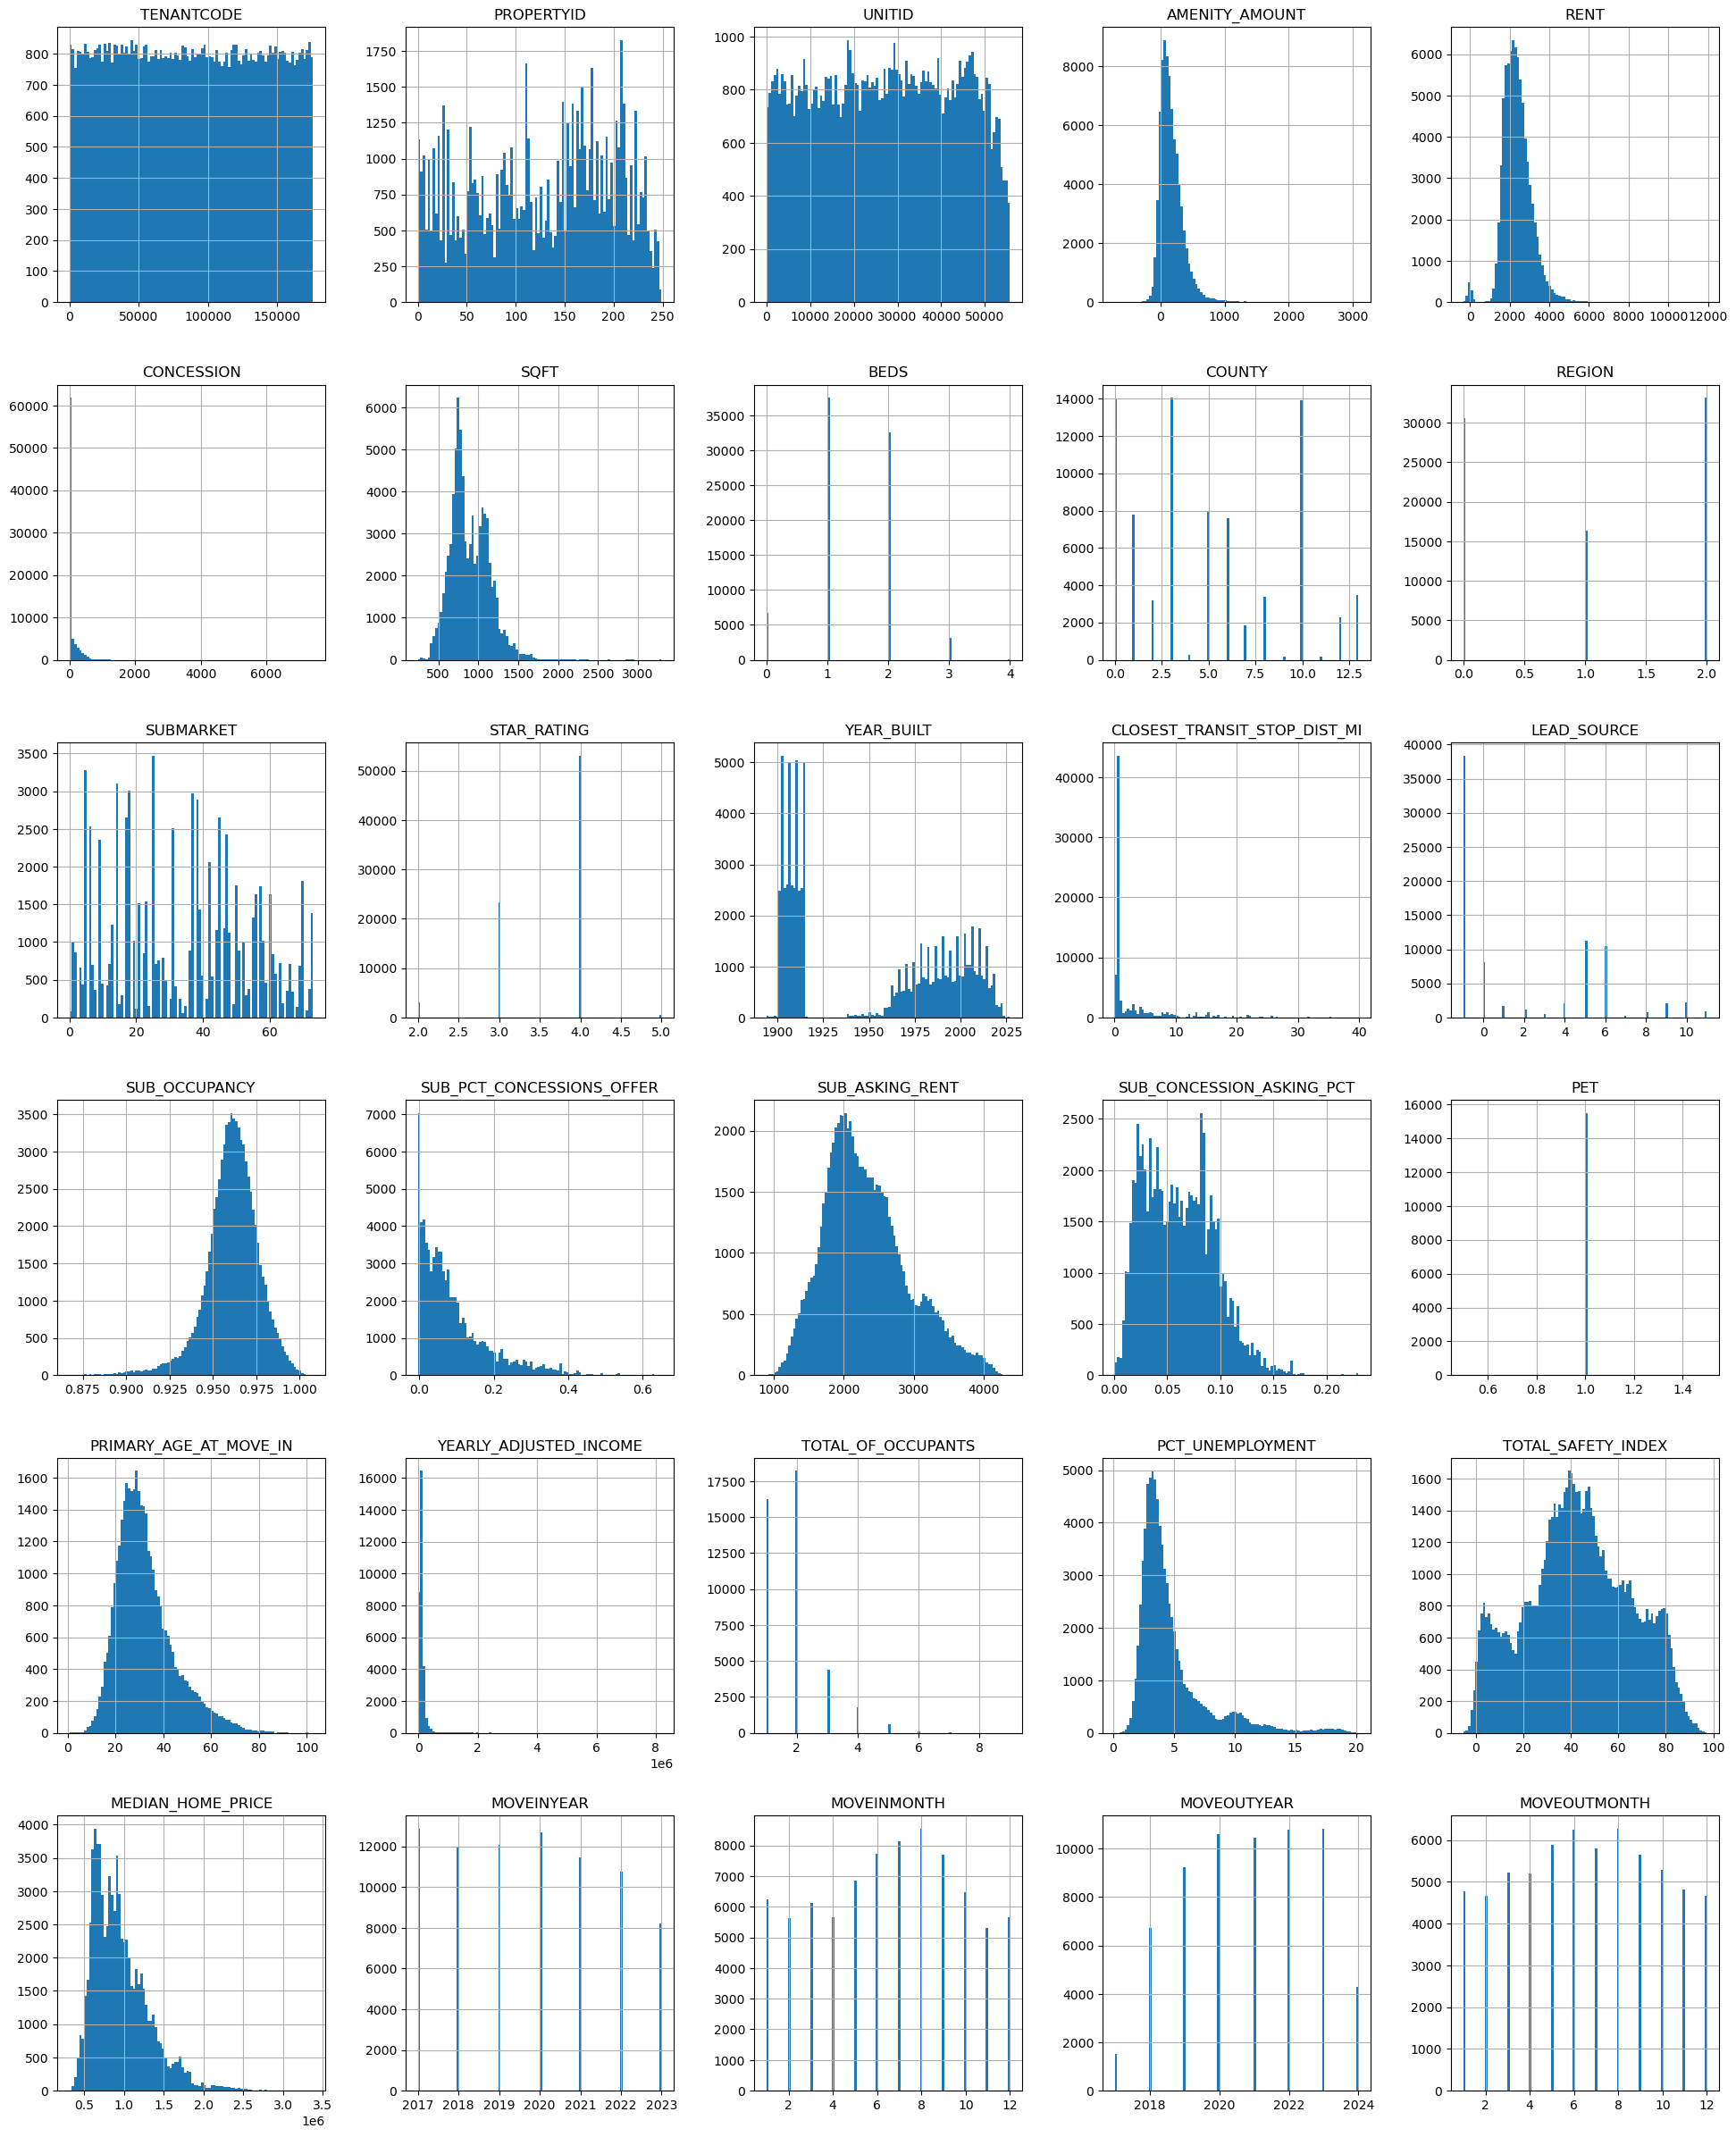

In [25]:
tenants.hist(bins=100, figsize = (24,30))
plt.show()

## Exploration:
### There's negative values for rent and amenity amount. Lets look at these data points because this is strange:
#### Take-away: There's no distinguishing feature to these tenants with negative rent from the entire population. These could be tenants that have special rates like employees such as SUPERINTENDENTS and their families or there could be an issue with this data logging

Number of data points with negative rent: 494 or 0.006175% of the tenant data


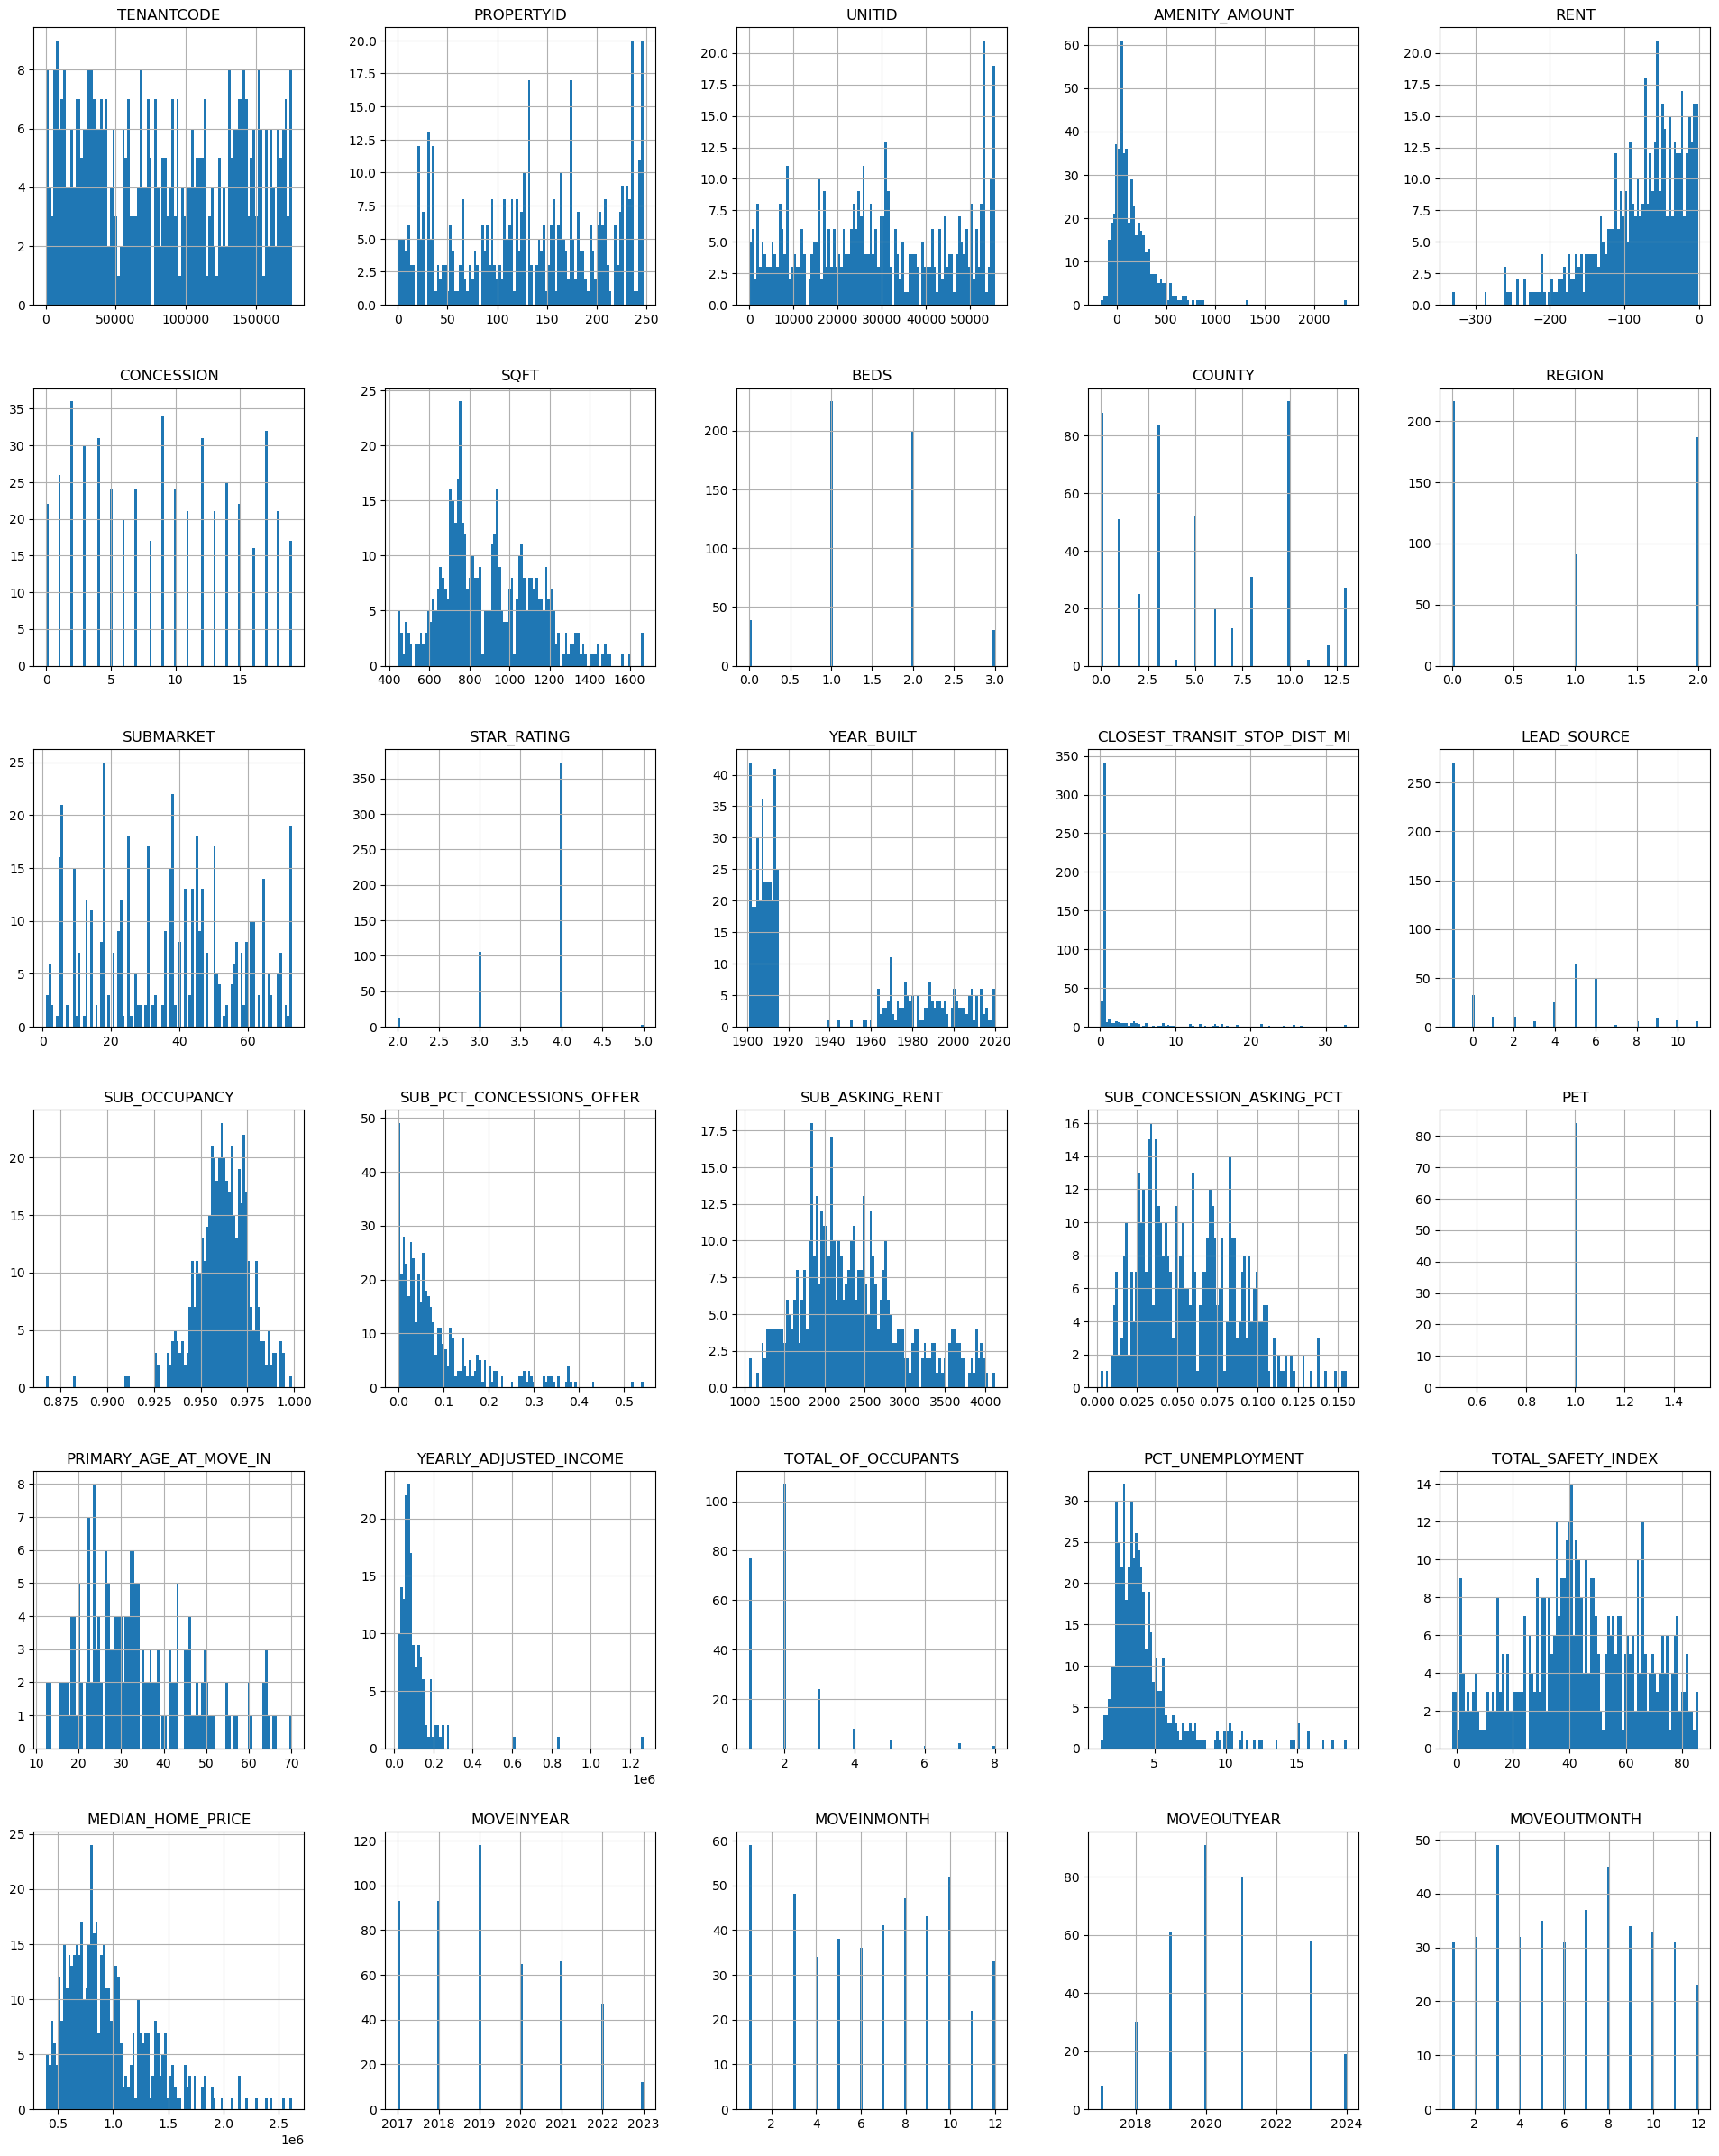

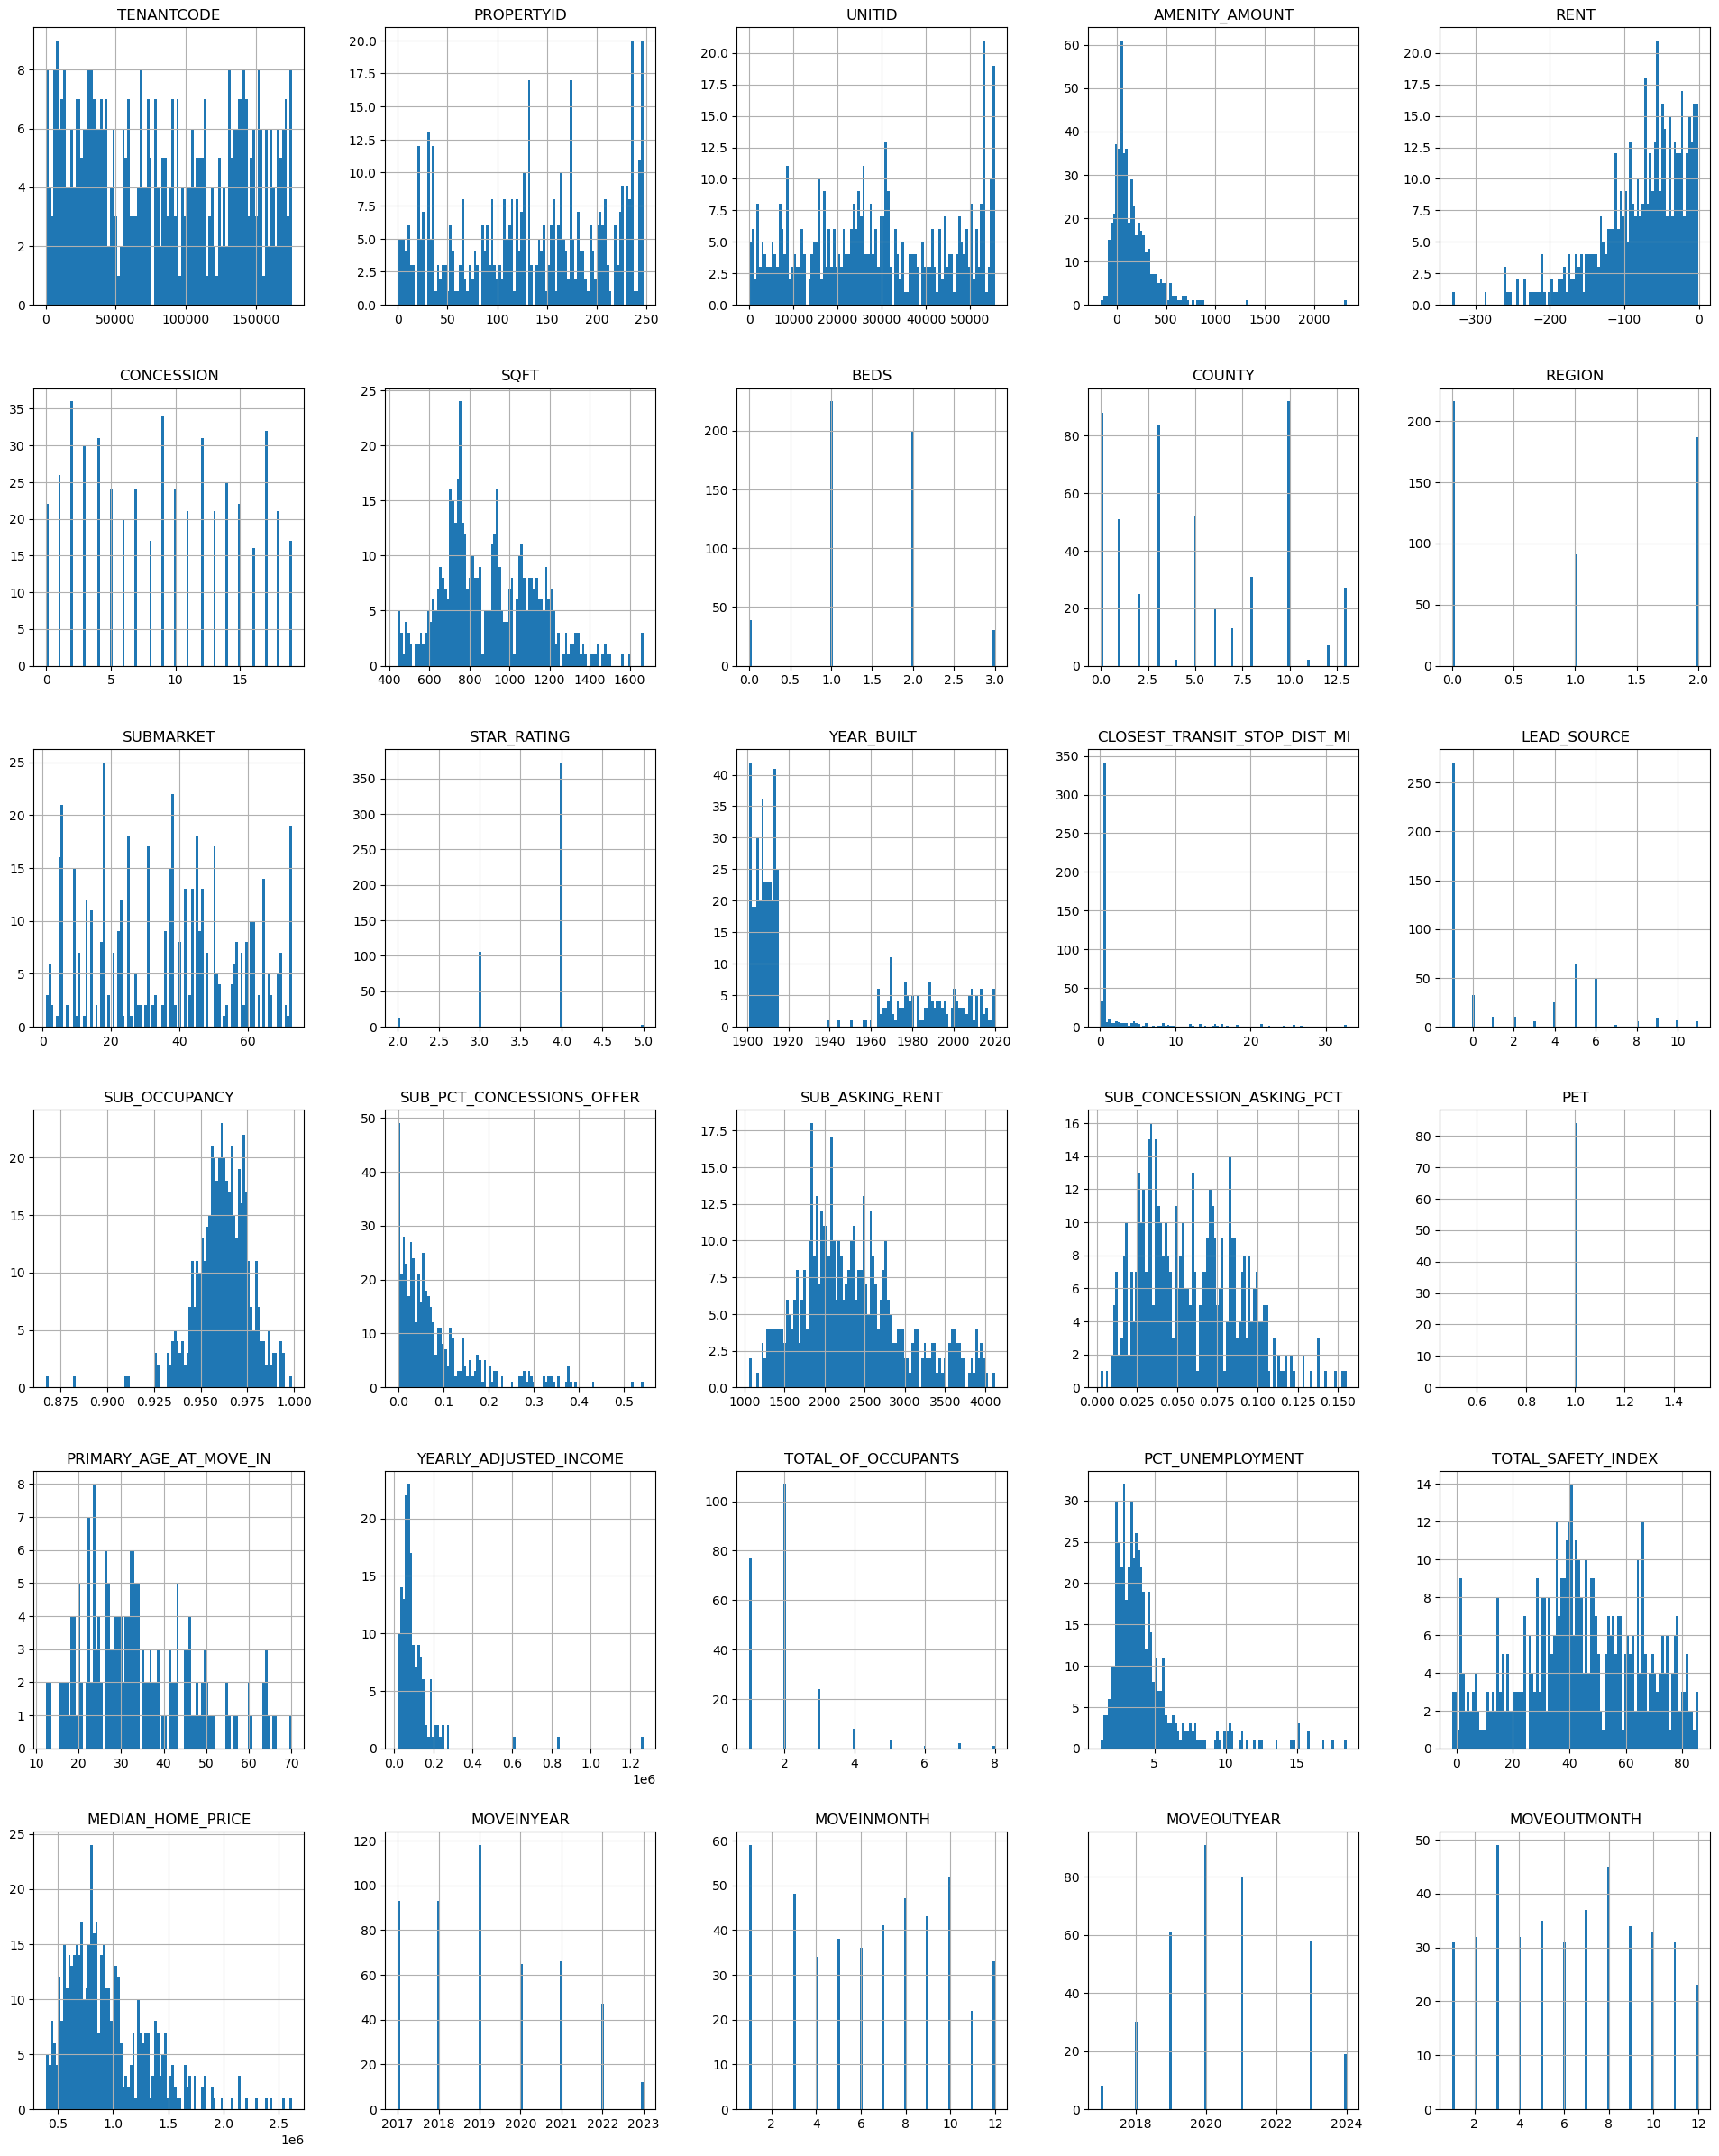

In [27]:
negrent_data = tenants[tenants['RENT']<0]#[['RENT','SUB_ASKING_RENT']]
percen_neg = len(negrent_data)/len(tenants)
print('Number of data points with negative rent: '+ str(len(negrent_data)) +' or ' + str(percen_neg)+'% of the tenant data')
negrent_data.hist(bins=100, figsize = (24,30))
plt.show()
negrent_data.hist(bins=100, figsize = (24,30))
plt.show()

# Sources of missing data

### Missing Submarket Attributes
- These categories all coincide in missing data, so this data was not collected.

- I'll use the median values of all tenants for ['SUB_OCCUPANCY', 'SUB_ASKING_RENT', 'SUB_CONCESSION_ASKING_PCT'] columns for the missing data here.

- For SUB_PCT_CONCESSIONS_OFFER, I'll use the mean of all the tenants as the data is skewed and there's large variation within submarket tenants.

In [31]:
columns_to_check = ['TENANTCODE','SUB_OCCUPANCY', 'SUB_PCT_CONCESSIONS_OFFER', 'SUB_ASKING_RENT', 'SUB_CONCESSION_ASKING_PCT']
tenants_na = tenants.dropna(how='all', subset=columns_to_check)
grouped = tenants_na.groupby(['SUBMARKET'])
stats_df = grouped.agg(
    counts_tenants=('TENANTCODE', 'count'),
    num_counties=('COUNTY', 'nunique'),
    num_regions=('REGION', 'nunique'),
    num_properties=('PROPERTYID', 'nunique'),
    num_units=('UNITID', 'nunique'),
    subocc_median=('SUB_OCCUPANCY', 'median'),
    subocc_std=('SUB_OCCUPANCY', 'std'),
    subconcoff_median=('SUB_PCT_CONCESSIONS_OFFER', 'median'),
    subconcoff_std=('SUB_PCT_CONCESSIONS_OFFER', 'std'),
    subaskrent_median=('SUB_ASKING_RENT', 'median'),
    subaskrent_std=('SUB_ASKING_RENT', 'std'),
    subconcask_median=('SUB_CONCESSION_ASKING_PCT', 'median'),
    subconcask_std=('SUB_CONCESSION_ASKING_PCT', 'std'),
).reset_index()

columns_to_check = ['SUB_OCCUPANCY', 'SUB_PCT_CONCESSIONS_OFFER', 'SUB_ASKING_RENT', 'SUB_CONCESSION_ASKING_PCT']

print('Set of submarkets for all of the tenants'+str(set(tenants['SUBMARKET'])))
tenants_isna = tenants[tenants[columns_to_check].isna().all(axis=1)]
print('Set of submarkets which are missing submarket tenants'+str(set(tenants_isna['SUBMARKET'])))
tenants_na = tenants.dropna(how='all', subset=columns_to_check)
sub_withoutnan = set(tenants_na['SUBMARKET']) - set(tenants_isna['SUBMARKET'])
print('Set of submarkets with complete submarket tenants'+str(sub_withoutnan))

print('Possible number of regions in a submarket: '+ str(set(stats_df['num_regions'])))
print('Possible number of counties in a submarket: '+str(set(stats_df['num_counties'])))
## 
print("If the sum is 80,000, then there's only entire rows of missing submarket tenants:")
print(len(tenants_isna[columns_to_check]) + 78648) #The number of non-null counts for each of these attributes
print("\nSubmarket Statistics DataFrame:")
stats_df

Set of submarkets for all of the tenants{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73}
Set of submarkets which are missing submarket tenants{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 73}
Set of submarkets with complete submarket tenants{0, 34, 71, 72, 30}
Possible number of regions in a submarket: {1}
Possible number of counties in a submarket: {1, 2}
If the sum is 80,000, then there's only entire rows of missing submarket tenants:
80000

Submarket Statistics DataFrame:


SUBMARKET  counts_tenants  num_counties  num_regions  num_properties  \
0           0              78             1            1               1   
1           1             994             1            1               4   
2           2             864             1            1               3   
3           3             663             1            1               3   
4           4             441             1            1               1   
..        ...             ...           ...          ...             ...   
69         69             685             1            1               3   
70         70            1811             1            1               6   
71         71              97             1            1               1   
72         72             376             1            1               1   
73         73            1380             1            1               3   

    num_units  subocc_median  subocc_std  subconcoff_median  subconcoff_std  \
0          45       0.958400    0.026048           0.001669        0.155943   
1         574       0.958606    0.008549           0.076365        0.081698   
2         504       0.958549    0.007182           0.087485        0.083240   
3         342       0.947964    0.016369           0.183839        0.105406   
4         238       0.972810    0.009357           0.036190        0.037880   
..        ...            ...         ...                ...             ...   
69        387       0.948005    0.017696           0.195644        0.078327   
70        916       0.972857    0.009283           0.072907        0.042189   
71         59       0.965499    0.009931           0.048077        0.053431   
72        190       0.965727    0.009097           0.068955        0.034473   
73        838       0.942399    0.022832           0.039477        0.062383   

    subaskrent_median  subaskrent_std  subconcask_median  subconcask_std  
0         3349.888128      200.367862           0.114994        0.031794  
1         2450.724992      133.835291           0.067398        0.031124  
2         2558.089164      180.717650           0.059925        0.019195  
3         2026.028588      137.170455           0.092577        0.026048  
4         1842.659093      305.190234           0.042683        0.020195  
..                ...             ...                ...             ...  
69        2366.223063      168.914804           0.095902        0.020071  
70        1774.684740      226.424383           0.029681        0.023623  
71        2113.669789      262.465934           0.056934        0.022478  
72        1805.074268      252.157259           0.059361        0.021198  
73        3347.300603      277.467120           0.105729        0.044162  

[74 rows x 14 columns]

### Missing Tenant provided data: Cleaning and Encoding to Numerical Values

In [33]:
print(data['INDUSTRY'].value_counts()) # INDUSTRY  87088 non-null   object
# Here, we have an unclassified and other category, so it seems like this data might just be unknown, nan ---> Unknown

INDUSTRY
1_Unclassified                                                              15581
Professional, Scientific, and Technical Services                            12238
Educational Services, Health Care and Social Assistance                     11406
Information                                                                  9844
Manufacturing                                                                8030
Retail Trade                                                                 6873
Public Administration                                                        4255
Finance and Insurance                                                        4081
Accommodation and Food Services                                              3296
Arts, Entertainment, and Recreation                                          2485
Other Services (except Public Administration)                                1902
Construction                                                                 1781
Transpo

In [34]:
## PET column
set(data['PET']) # Only value is 1. 1 Corresponds to having a pet, Nan when no pet --> change these to 0
def pet_nans(df):
    df['PET'] = df['PET'].fillna(0)
    #print('Pet-values after preparation step: ' + str(set(data['PET']))) # Changed

# MOVEOUTYEAR  and MOVEOUTMONTH, nan values perfectly coincide, nan --> Haven't moved out yet
# Set to current date
def moveout_nan(df):
    df['MOVEOUTYEAR'] = df['MOVEOUTYEAR'].fillna(2024)
    df['MOVEOUTMONTH'] = df['MOVEOUTMONTH'].fillna(9)

## Lease Term
set(data['LEASETERM']) # Unclear what Nan is here -- Is it a lack of a lease (month-to-month?)? nan -> 0, '(0, 5]' -> 1/4, '(5, 11]' -> 8.5/12, '(11, 12]' -> 1, '(12, 24]'-> 18.5
def lease_nans_transform(df):
    df['LEASETERM'] = df['LEASETERM'].fillna(0)
    mapping = {
    '(0, 5]': 0.25,   # Replace '(0, 5]' with 1/4
    '(5, 11]': 0.71, # Replace '(5, 11]' with 8.5/12
    '(11, 12]': 1,    # Replace '(11, 12]' with 1
    '(12, 24]': 1.54  # Replace '(12, 24]' with 18.5
    }
    df['LEASETERM'] = df['LEASETERM'].replace(mapping)

## Type of Move, nan ---> Unknown
set(data['TYPE_OF_MOVE']) # {'Same Zip Move', nan, 'Same City Move', 'Different City Move'} --> Unknown type of move? Could be within property or unknown
def move_nans(df):
    df['TYPE_OF_MOVE'] = df['TYPE_OF_MOVE'].fillna(3)
    mapping = {
    'Same Zip Move': 0,   # Replace '(0, 5]' with 1/4
    'Same City Move': 1, # Replace '(5, 11]' with 8.5/12
    'Different City Move': 2    # Replace '(11, 12]' with 1
    }
    df['TYPE_OF_MOVE'] = df['TYPE_OF_MOVE'].replace(mapping)

## Type of Industry, nan ---> Unknown
def industry_nans(df):
    df['INDUSTRY'] = df['INDUSTRY'].fillna('Unknown')
## Encoder for Industry
ordinal_encoder = OrdinalEncoder()

## Impute the median for:
# SUB_OCCUPANCY                 78648 non-null  float64
# SUB_ASKING_RENT               78648 non-null  float64
# SUB_CONCESSION_ASKING_PCT     78648 non-null  float64
# PRIMARY_AGE_AT_MOVE_IN        46525 non-null   float64
# TOTAL_OF_OCCUPANTS            51896 non-null   float64
# PCT_UNEMPLOYMENT              97146 non-null   float64
# MEDIAN_HOME_PRICE             97429 non-null   float64 

imputer_median = SimpleImputer(strategy='median')

## Impute the mean for:
# SUB_PCT_CONCESSIONS_OFFER     78648 non-null  float64

imputer_mean = SimpleImputer(strategy='mean')

#YEARLY_ADJUSTED_INCOME will be filled with the industry specific median

def impute_income_medians(df):
    """
    This function imputes missing values in the 'YEARLY_ADJUSTED_INCOME'
    column of the given DataFrame based on the median income for each industry.

    Parameters:
        df (pd.DataFrame): The DataFrame containing tenants' data.

    Returns:
        pd.DataFrame: The DataFrame with imputed values in 'YEARLY_ADJUSTED_INCOME'.
    """
    required_columns = ['INDUSTRY', 'YEARLY_ADJUSTED_INCOME']
    if not all(column in df.columns for column in required_columns):
        raise ValueError(f"The DataFrame must contain the following columns: {required_columns}")

    # Calculate median for each industry
    industry_medians = df.groupby('INDUSTRY')['YEARLY_ADJUSTED_INCOME'].median()

    # Define a function to fill missing values
    def fill_missing_income(row):
        if pd.isna(row['YEARLY_ADJUSTED_INCOME']):
            return industry_medians[row['INDUSTRY']]  # Fill with median income of the industry
        return row['YEARLY_ADJUSTED_INCOME']

    # Apply the function to fill NaN values
    df['YEARLY_ADJUSTED_INCOME'] = df.apply(fill_missing_income, axis=1)

    return df

In [39]:
med_impute_columns = ['SUB_OCCUPANCY','SUB_ASKING_RENT','SUB_CONCESSION_ASKING_PCT','PRIMARY_AGE_AT_MOVE_IN','TOTAL_OF_OCCUPANTS','PCT_UNEMPLOYMENT','MEDIAN_HOME_PRICE'] #YEARLY_ADJUSTED_INCOME
mean_impute_columns = ['SUB_PCT_CONCESSIONS_OFFER']

## Data Cleaning: Imputing nan - values and converting categorical data to numerical data

In [42]:
# Fit and transform for median columns
tenants[med_impute_columns] = imputer_median.fit_transform(tenants[med_impute_columns])

# Fit and transform for mean columns
tenants[mean_impute_columns] = imputer_mean.fit_transform(tenants[mean_impute_columns])
# Fit and transform the specified columns

pet_nans(tenants)
moveout_nan(tenants)
lease_nans_transform(tenants)
move_nans(tenants)
industry_nans(tenants)
tenants['INDUSTRY'] = ordinal_encoder.fit_transform(tenants[['INDUSTRY']])
impute_income_medians(tenants)

/var/folders/1w/f1nvvnys0db1_sj90qqds2780000gn/T/ipykernel_55760/1551715802.py:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['LEASETERM'] = df['LEASETERM'].replace(mapping)
/var/folders/1w/f1nvvnys0db1_sj90qqds2780000gn/T/ipykernel_55760/1551715802.py:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['TYPE_OF_MOVE'] = df['TYPE_OF_MOVE'].replace(mapping)


TENANTCODE  PROPERTYID  UNITID  AMENITY_AMOUNT  LEASETERM  RENT  \
10284       90024         148   38280              37       1.00  1706   
57225       64392         233   52491              50       1.00  2721   
37369       85391         112   22751             225       0.71  2599   
91583      119573          90   16871              80       1.00  2583   
82002       57742         246   55397             -90       1.54  3143   
...           ...         ...     ...             ...        ...   ...   
35023       30625         177   32060             273       1.00  2326   
43894       90715         170   39262              80       1.00  2306   
86698         631           0     493             233       1.00  2352   
56470      101741         121   23829             270       1.00  2895   
80952       51820         121   23894             185       1.54  1599   

       CONCESSION  SQFT  BEDS  COUNTY  ...  PRIMARY_AGE_AT_MOVE_IN  \
10284          44   929     2       6  ...               30.262650   
57225         376  1127     2       1  ...               29.659697   
37369          16  1020     3       3  ...               14.121521   
91583           8  1058     2       2  ...               37.088784   
82002          17  1050     2       0  ...               30.262650   
...           ...   ...   ...     ...  ...                     ...   
35023         337   773     1       1  ...               29.298425   
43894          94   755     1       6  ...               34.467184   
86698          13  1007     2       0  ...               30.262650   
56470           9  1058     2       5  ...               62.502126   
80952           0   697     1       5  ...               30.262650   

       YEARLY_ADJUSTED_INCOME  TOTAL_OF_OCCUPANTS  PCT_UNEMPLOYMENT  \
10284             80323.19162                 2.0          3.883569   
57225             45868.09765                 2.0          7.345518   
37369             85753.25349                 2.0          2.879554   
91583             89284.36718                 3.0          3.975992   
82002             93224.87185                 1.0         10.055102   
...                       ...                 ...               ...   
35023            135961.70730                 2.0          7.408368   
43894             80165.82556                 3.0          3.480628   
86698            101923.22515                 2.0          4.333733   
56470             82854.72931                 2.0          3.206745   
80952            101923.22515                 2.0          2.468743   

       TOTAL_SAFETY_INDEX  MEDIAN_HOME_PRICE  MOVEINYEAR  MOVEINMONTH  \
10284           77.978376       5.827798e+05        2017            1   
57225            0.288229       6.384079e+05        2020           12   
37369           49.675072       1.182281e+06        2022           11   
91583           72.330452       1.683869e+06        2023            1   
82002           54.004709       8.575926e+05        2021            2   
...                   ...                ...         ...          ...   
35023           59.556659       1.044608e+06        2021            3   
43894           68.982331       9.344703e+05        2022           11   
86698           61.943721       7.097703e+05        2019            8   
56470           26.515517       1.072738e+06        2023            5   
80952           31.685504       8.167869e+05        2018           12   

       MOVEOUTYEAR  MOVEOUTMONTH  
10284       2020.0           1.0  
57225       2022.0           7.0  
37369       2023.0           7.0  
91583       2024.0           9.0  
82002       2023.0           2.0  
...            ...           ...  
35023       2022.0           3.0  
43894       2024.0           9.0  
86698       2019.0           8.0  
56470       2024.0           2.0  
80952       2020.0          10.0  

[80000 rows x 33 columns]

In [44]:
tenants.info() #All missing data has been addressed

<class 'pandas.core.frame.DataFrame'>
Index: 80000 entries, 10284 to 80952
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   TENANTCODE                    80000 non-null  int64  
 1   PROPERTYID                    80000 non-null  int64  
 2   UNITID                        80000 non-null  int64  
 3   AMENITY_AMOUNT                80000 non-null  int64  
 4   LEASETERM                     80000 non-null  float64
 5   RENT                          80000 non-null  int64  
 6   CONCESSION                    80000 non-null  int64  
 7   SQFT                          80000 non-null  int64  
 8   BEDS                          80000 non-null  int64  
 9   COUNTY                        80000 non-null  int64  
 10  REGION                        80000 non-null  int64  
 11  SUBMARKET                     80000 non-null  int64  
 12  STAR_RATING                   80000 non-null  int64  
 13  YE

## Time Span of Data

In [47]:
print('Move In Years: ' + str(set(data['MOVEINYEAR'])))
print('Earliest Move In Month/Year:', str(tenants[tenants['MOVEINYEAR']==tenants['MOVEINYEAR'].min()]['MOVEINMONTH'].min()) + '/' + str(tenants['MOVEINYEAR'].min()))
print('Latest Move In Month/Year:', str(tenants[tenants['MOVEINYEAR']==tenants['MOVEINYEAR'].max()]['MOVEINMONTH'].max()) + '/' + str(tenants['MOVEINYEAR'].max()))
print('Latest Move Out Month/Year:', str(tenants[tenants['MOVEOUTYEAR']==tenants['MOVEOUTYEAR'].max()]['MOVEOUTMONTH'].max()) + '/' + str(tenants['MOVEOUTYEAR'].max()))
print('--> Going to calculate number of months from ' + str(tenants[tenants['MOVEINYEAR']==tenants['MOVEINYEAR'].min()]['MOVEINMONTH'].min()) + '/' + str(tenants['MOVEINYEAR'].min()))
Mnum_total= (2023-2017)* 12 + (9-1)
print('Span of number of MOVE-IN months: ' + str(Mnum_total))

Move In Years: {2017, 2018, 2019, 2020, 2021, 2022, 2023}
Earliest Move In Month/Year: 1/2017
Latest Move In Month/Year: 9/2023
Latest Move Out Month/Year: 9.0/2024.0
--> Going to calculate number of months from 1/2017
Span of number of MOVE-IN months: 80


In [49]:
### Simplifying the time data
tenants['MoveInMnum'] = 12*(tenants['MOVEINYEAR'] - tenants['MOVEINYEAR'].min()) + (tenants['MOVEINMONTH'] - tenants[tenants['MOVEINYEAR']==tenants['MOVEINYEAR'].min()]['MOVEINMONTH'].min())
tenants['MoveOutMnum'] = 12*(tenants['MOVEOUTYEAR'] - tenants['MOVEINYEAR'].min()) + (tenants['MOVEOUTMONTH'] - tenants[tenants['MOVEINYEAR']==tenants['MOVEINYEAR'].min()]['MOVEINMONTH'].min())
tenants['OccupancyMonths'] = tenants['MoveOutMnum'] - tenants['MoveInMnum']

In [51]:
# Comparing number of months occupied vs lease period signed for.
# If tenant leaves early: -1 , on time: 0, stays longer than initial lease period: 1
def occtolease(row):
    x = row['OccupancyMonths']
    if row['LEASETERM'] == 0:
        return 0
    elif row['LEASETERM'] == 0.25:
        return 0 if (x > 0) and (x <= 5) else 1
    elif row['LEASETERM'] == 0.71:
        if x <= 5:
            return -1
        elif (x > 5) and (x <= 11):
            return 0
        else:
            return 1
    elif row['LEASETERM'] == 1:
        if x <= 11:
            return -1
        elif (x > 11) and (x <= 12):
            return 0
        else:
            return 1
    elif row['LEASETERM'] == 1.54:
        if x <= 12:
            return -1
        elif (x > 12) and (x <= 24):
            return 0
        else:
            return 1
    return 1  # Default return value if no conditions are met

# Apply function to each row in the DataFrame
tenants['OccVsLease'] = tenants.apply(occtolease, axis=1)

# Correlations between Columns

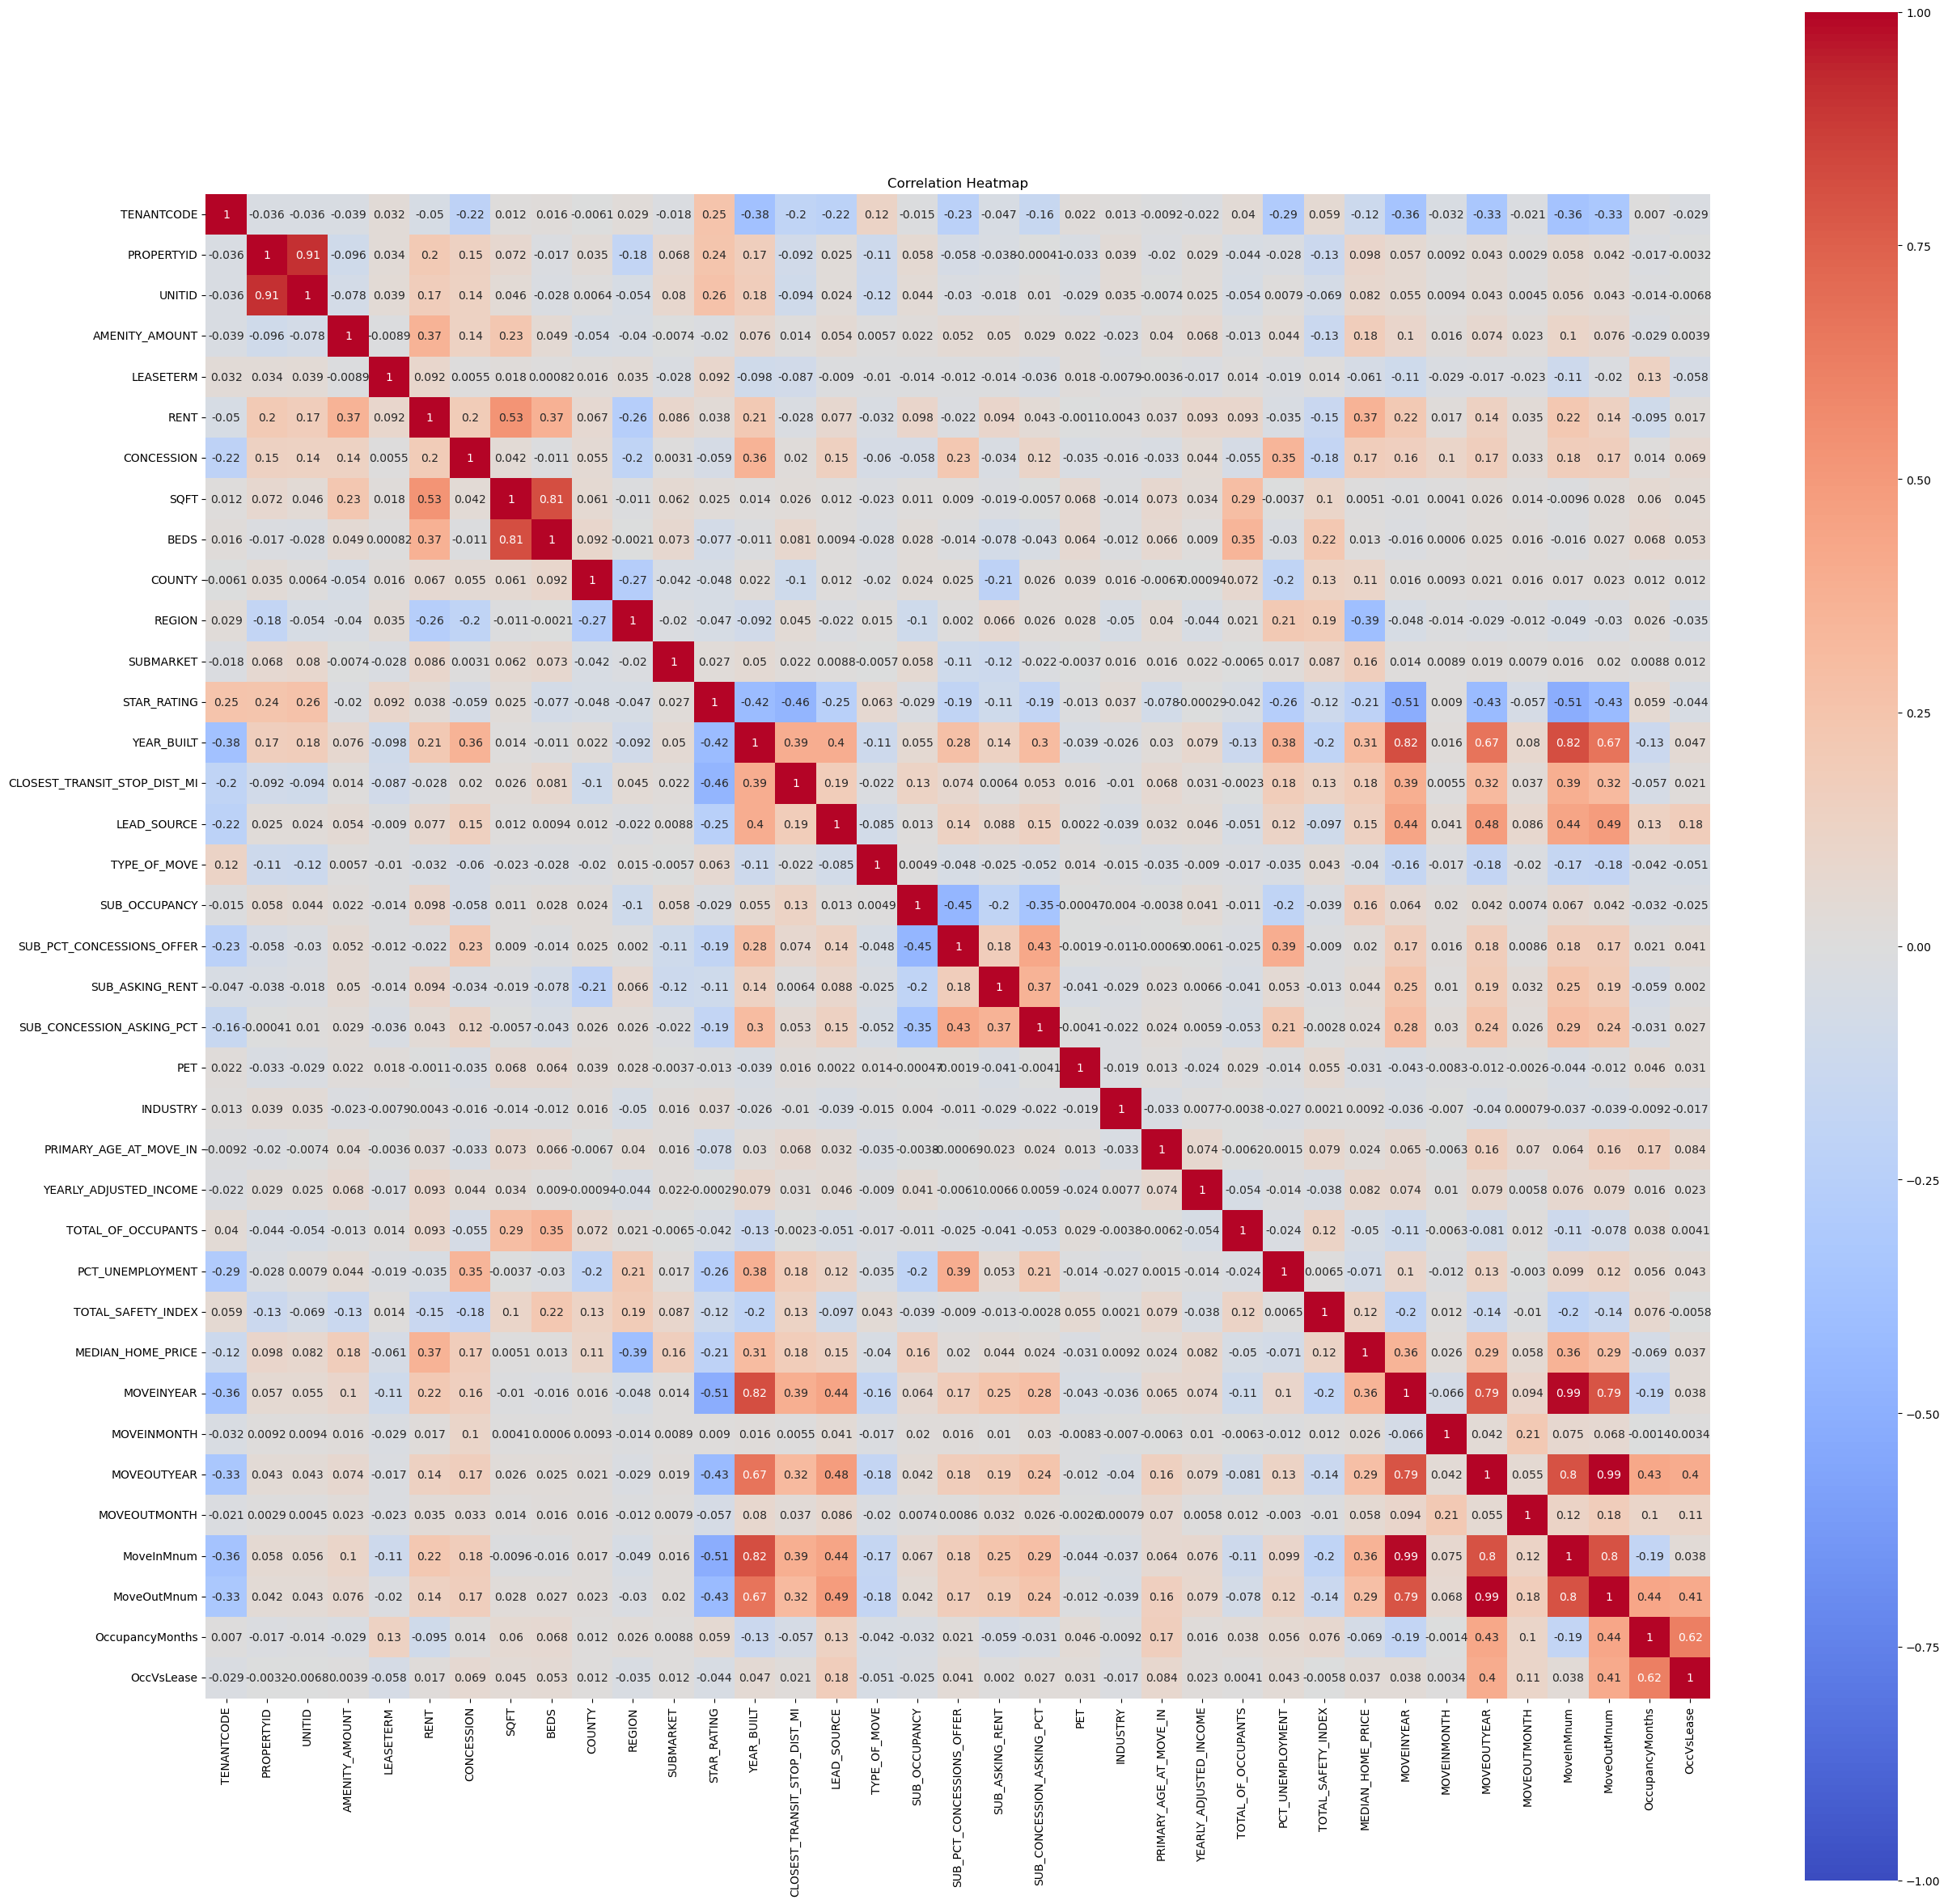

In [54]:
correlation_matrix = tenants.corr()

# Correlation Visualization 1
plt.figure(figsize=(30, 30))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True)
plt.title('Correlation Heatmap')
plt.savefig('correlation_heatmap.png', dpi=500, bbox_inches='tight')  # Save as PNG
plt.show()

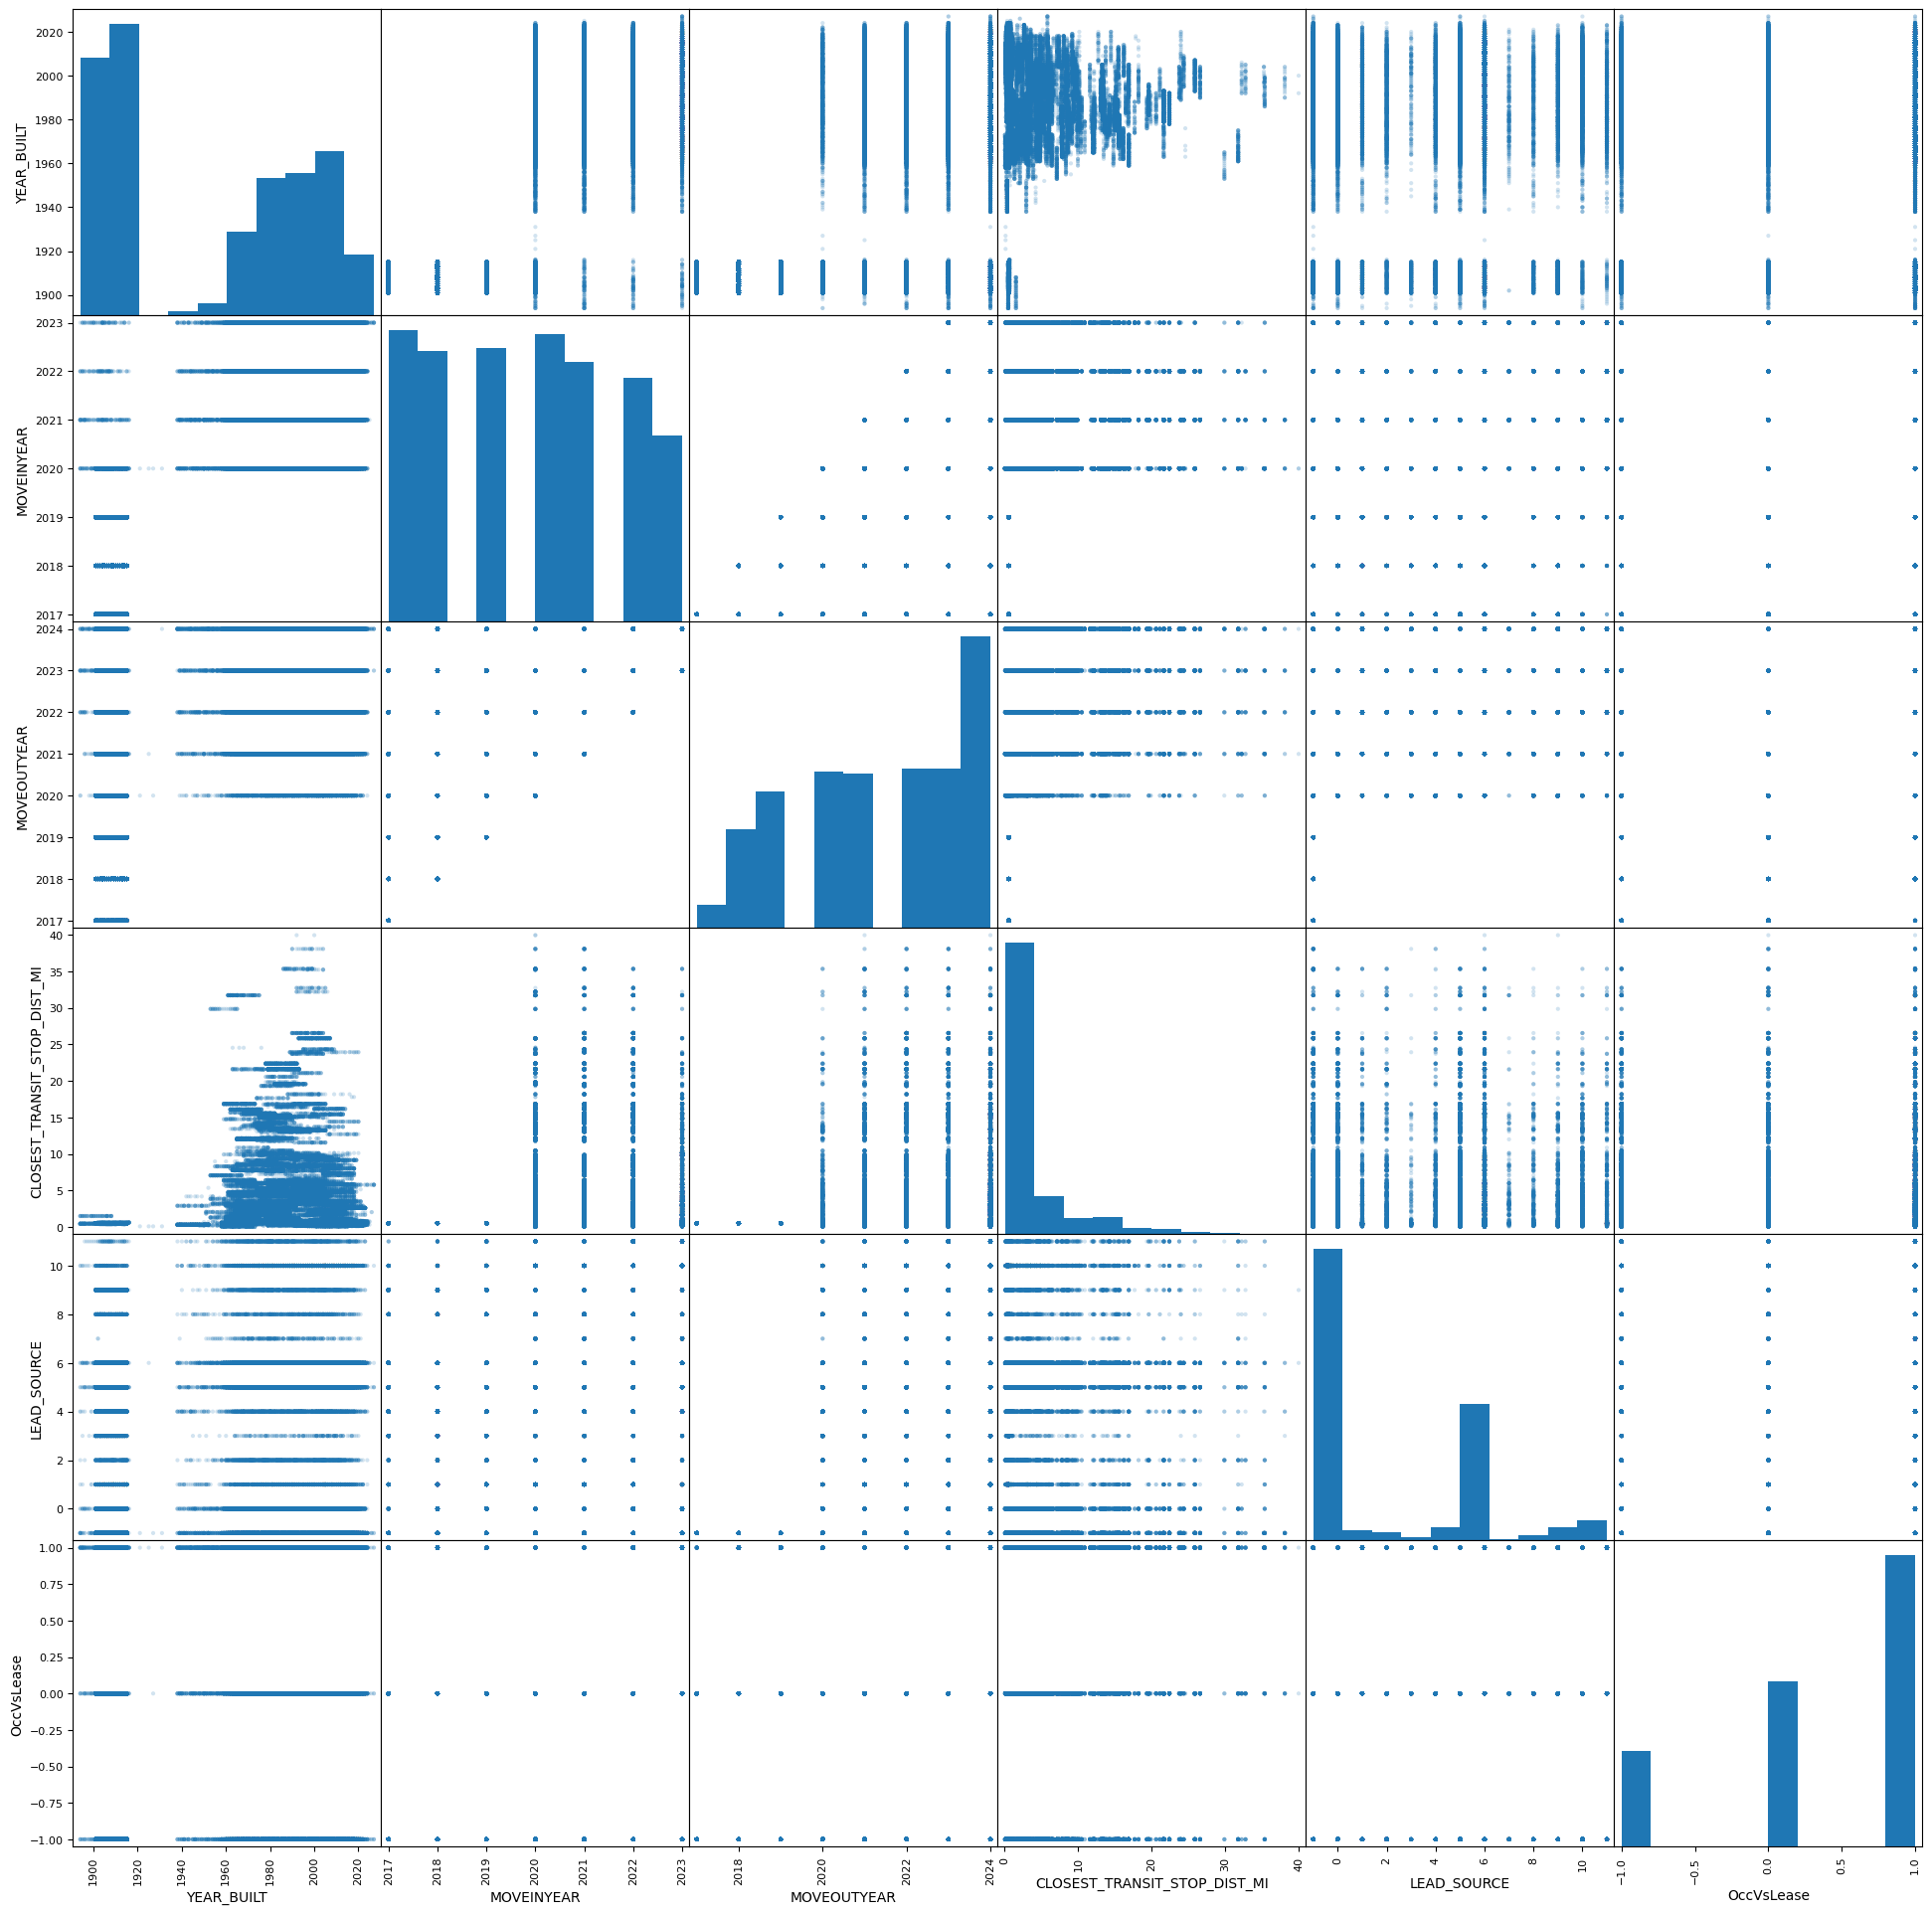

In [55]:
attributes = ['YEAR_BUILT','MOVEINYEAR','MOVEOUTYEAR','CLOSEST_TRANSIT_STOP_DIST_MI','LEAD_SOURCE','OccVsLease']

scatter_matrix(tenants[attributes], figsize =(24,24), alpha =0.2)
plt.show()

## YEAR_BUILT Correlates strongly with several columns

In [57]:
def build_year_plot(value,i,bin):
    axes[i].hist(old_build[value], bins=bin, edgecolor='black', alpha=0.2, label='Old Build')
    axes[i].hist(new_build[value], bins=bin, edgecolor='black', alpha=0.2, label='New Build')
    axes[i].set_title(str(value)+' Distribution')
    axes[i].set_xlabel(value)
    axes[i].set_ylabel('Counts')
    axes[i].grid(True)
    axes[i].legend()

### Earliest move-in year for the newer build is: 2020 and month is 2
### This must've been when the properties were acquired.

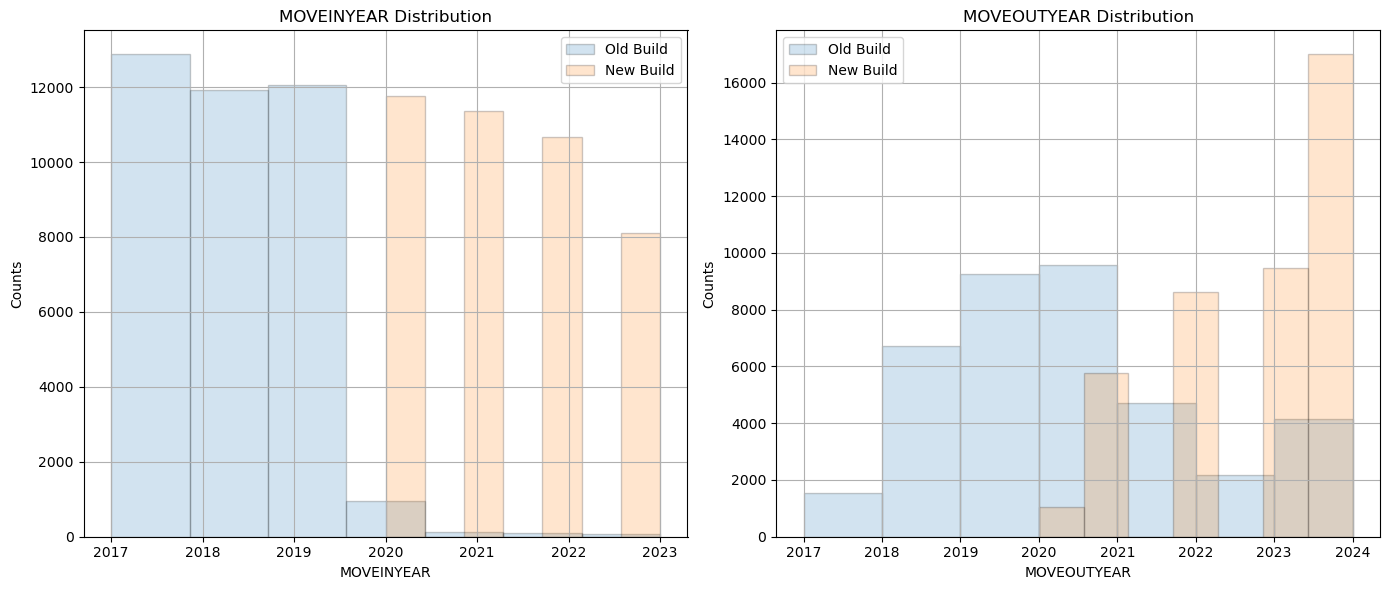

Earliest move-in year for the newer build is: 2020 and month is 2
This must've been when the properties were acquired.


In [59]:
# Categorizing year of build by old (0) vs. new (1)
set(tenants['YEAR_BUILT'])
old_build = tenants[tenants['YEAR_BUILT']<1925]
new_build = tenants[tenants['YEAR_BUILT']>=1925]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns
# Histogram for move in year
build_year_plot('MOVEINYEAR',0,7)
# Histogram for move out year
build_year_plot('MOVEOUTYEAR',1,7)
plt.savefig('year_build_Move_year.png', dpi=500, bbox_inches='tight')  # Save as PNG
plt.tight_layout()
plt.show()

print('Earliest move-in year for the newer build is: ' + str(new_build['MOVEINYEAR'].min()) + ' and month is ' +str(new_build[new_build['MOVEINYEAR']==new_build['MOVEINYEAR'].min()]['MOVEINMONTH'].min()))
print("This must've been when the properties were acquired.")

### Old Builds have longer Residency periods because they've had tenants for longer (since 2017) compared to new builds (since 2020)

55


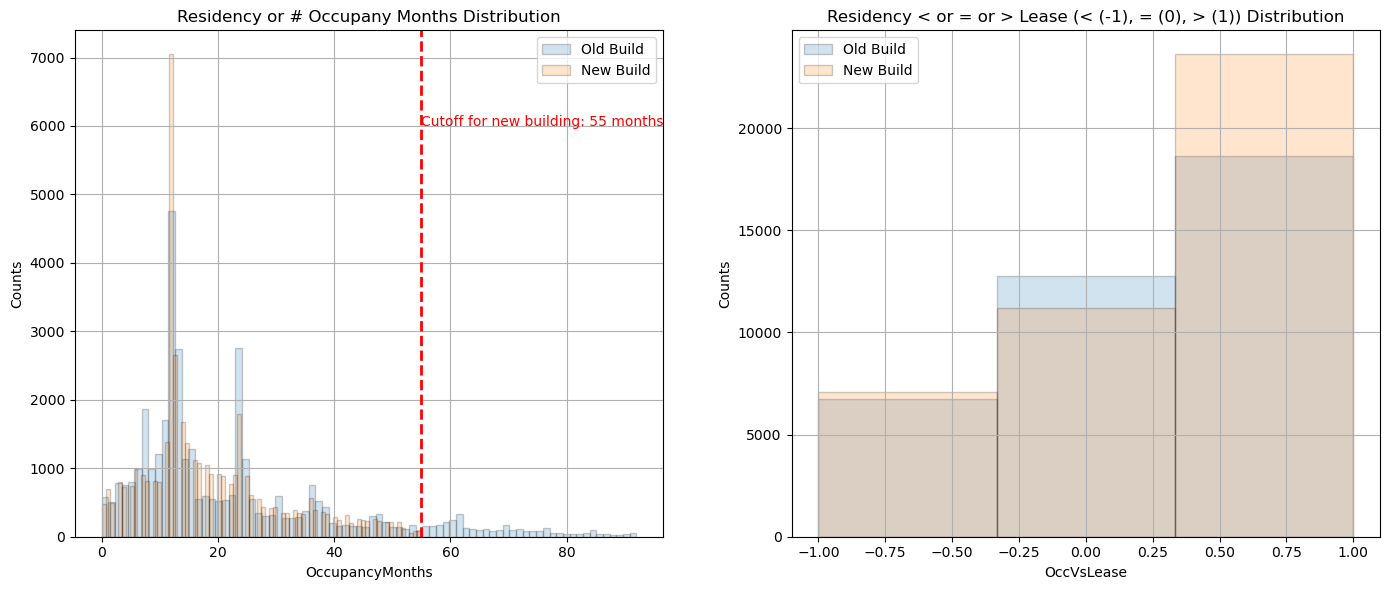

In [61]:
# Latest Move OUT Month/Year: 9/2024
Mnum_cutoff_new= (2024-2020)* 12 + (9-2)
print(Mnum_cutoff_new)
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns
# Histogram for move in year
build_year_plot('OccupancyMonths',0,80)
axes[0].axvline(x=Mnum_cutoff_new, color='red', linestyle='dashed', linewidth=2)
axes[0].text(Mnum_cutoff_new, 6000, f'Cutoff for new building: {Mnum_cutoff_new} months', color='red')
axes[0].set_title('Residency or # Occupany Months Distribution')
# Histogram for move out year
build_year_plot('OccVsLease',1,3)
axes[1].set_title('Residency < or = or > Lease (< (-1), = (0), > (1)) Distribution')
plt.savefig('year_build_residency.png', dpi=500, bbox_inches='tight')  # Save as PNG

plt.tight_layout()
plt.show()

In [63]:
print(len(old_build))
print(len(old_build[(old_build['MOVEOUTYEAR']==2024) & (old_build['MOVEOUTMONTH']==9)]))
print(len(new_build))
print(len(new_build[(new_build['MOVEOUTYEAR']==2024) & (new_build['MOVEOUTMONTH']==9)]))

38106
2338
41894
13161


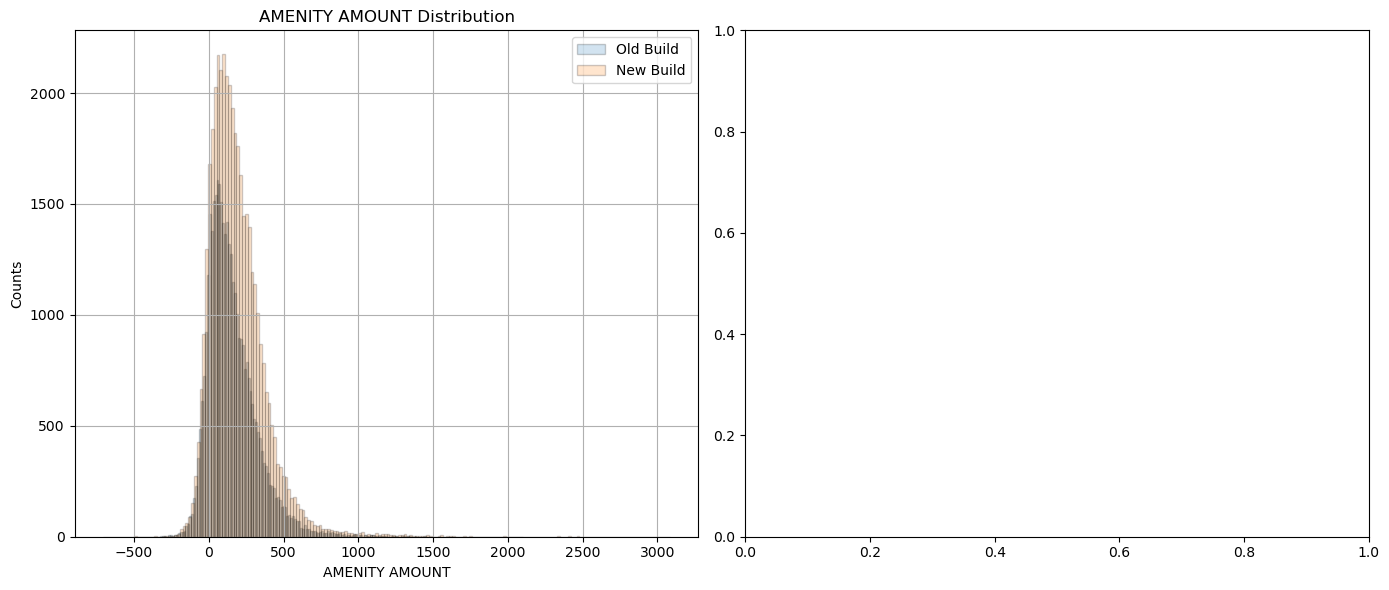

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns
build_year_plot('AMENITY_AMOUNT',0,200)
axes[0].set_title('AMENITY AMOUNT Distribution')
axes[0].set_xlabel('AMENITY AMOUNT')
axes[0].set_ylabel('Counts')
plt.savefig('year_build_amenity.png', dpi=500, bbox_inches='tight')  # Save as PNG
plt.tight_layout()
plt.show()

## Old and New Builds are not segregated by region, country or submarket. Old builds are all more close to transit

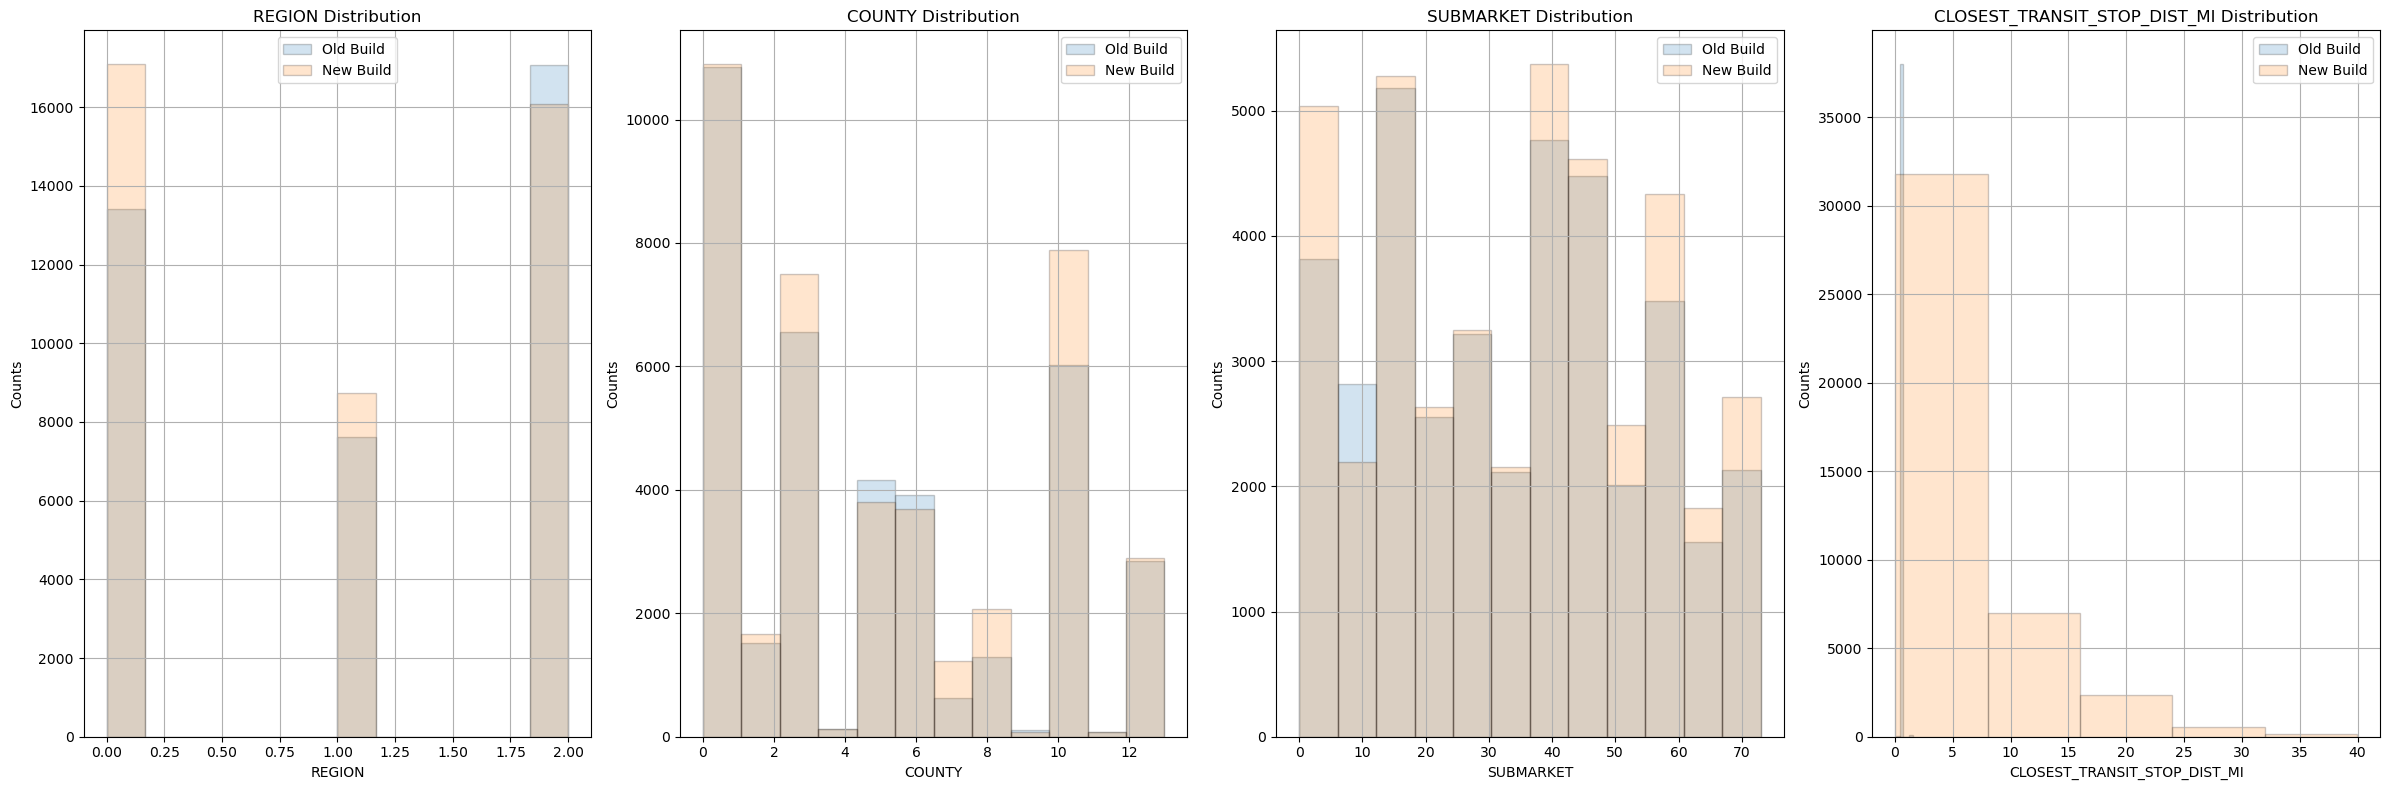

In [72]:
# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(24, 8))  # 1 row, 2 columns
# Histogram for Region
build_year_plot('REGION',0,12)
# Histogram for COUNTY
build_year_plot('COUNTY',1,12)
# Histogram for SUBMARKET
build_year_plot('SUBMARKET',2,12)
# Histogram for Transit
build_year_plot('CLOSEST_TRANSIT_STOP_DIST_MI',3,5)
plt.savefig('year_build_geographical.png', dpi=500, bbox_inches='tight')  # Save as PNG

plt.tight_layout()
plt.show()

In [74]:
# Create subplots
tenants['Payment'] = tenants['RENT'] + tenants['AMENITY_AMOUNT'] - tenants['CONCESSION']
tenants['Ideal_Payment'] = tenants['SUB_ASKING_RENT'] - tenants['SUB_CONCESSION_ASKING_PCT']
tenants['net_pay'] = tenants['Payment'] - tenants['Ideal_Payment']
tenants['PaymentperSQFT'] = tenants['Payment']/tenants['SQFT']
tenants['net_payperSQFT'] = tenants['Ideal_Payment']/tenants['SQFT']
old_build = tenants[tenants['YEAR_BUILT']<1925]
new_build = tenants[tenants['YEAR_BUILT']>=1925]

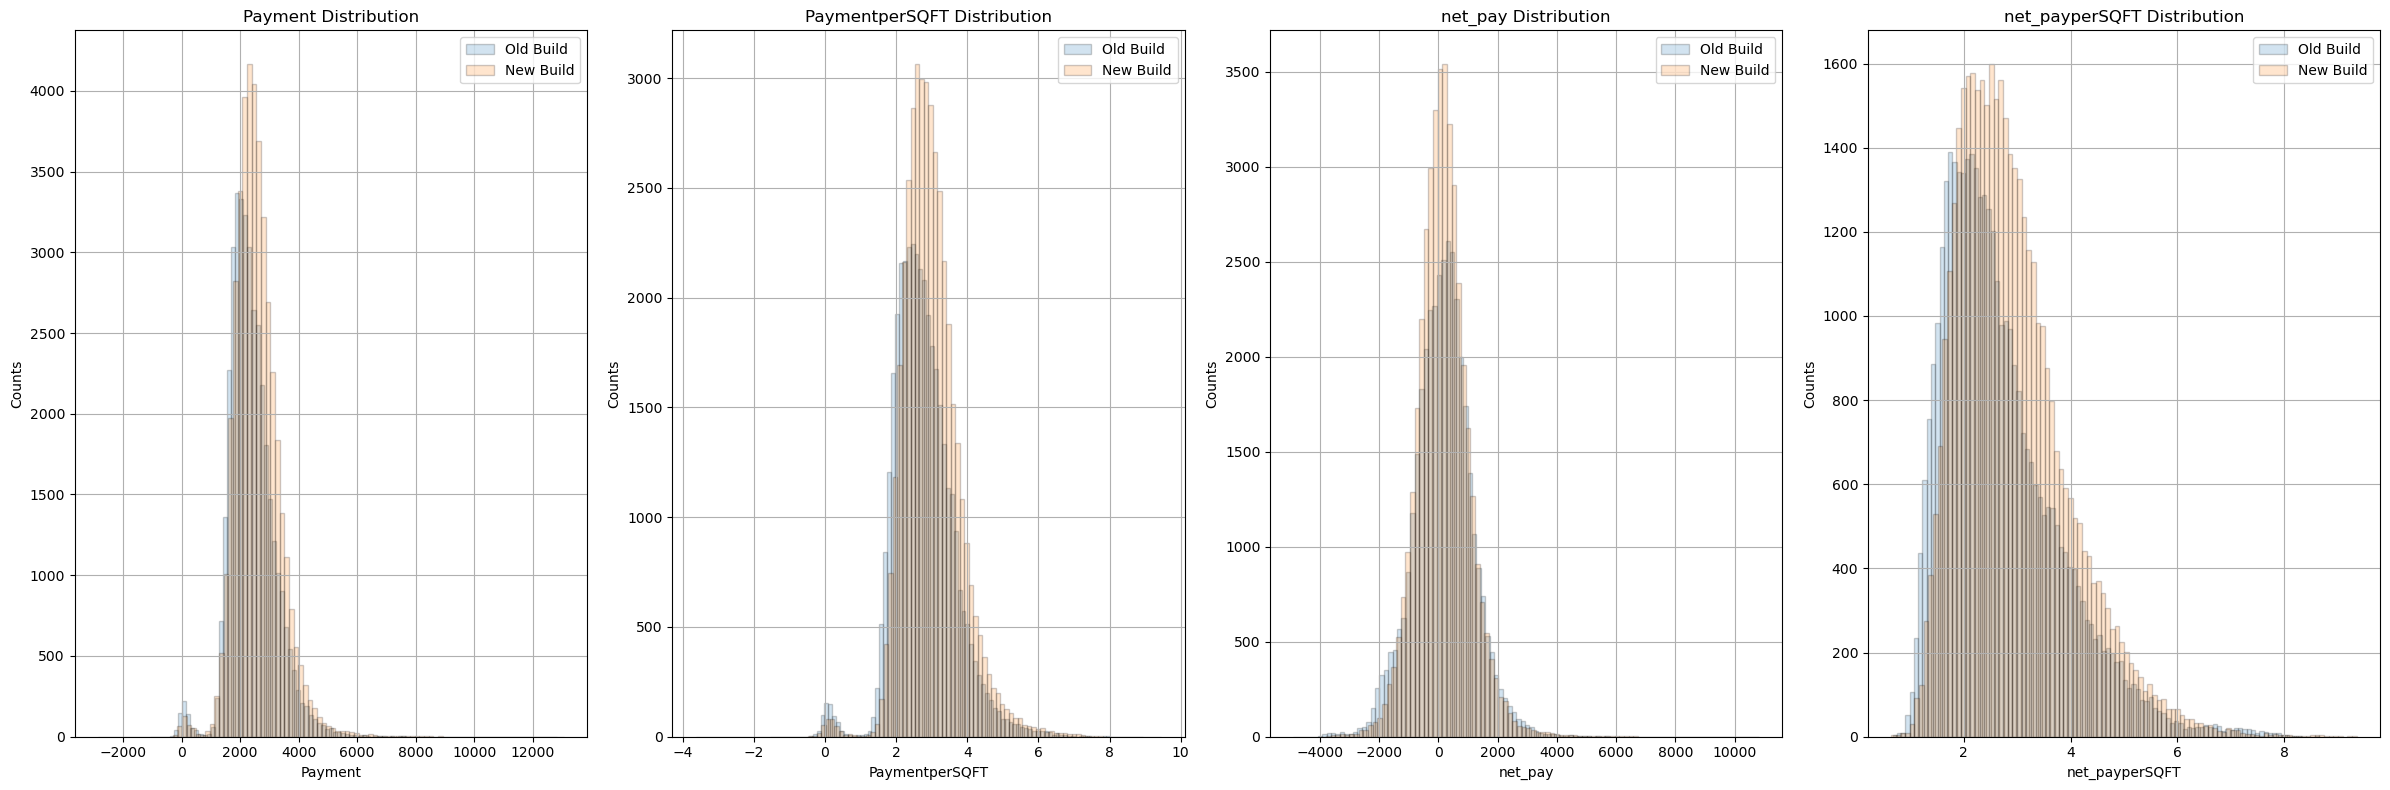

Median Payment for old build: 2280.0
Median Payment for new build: 2486.0
Median Payment per SQFT for old build: 2.673442595289994
Median Payment per SQFT for new build: 2.8935956592326755
Median Net Pay for old build: 169.58258448300012
Median Net Pay for new build: 133.1332149745
Median Net Pay per SQFT for old build: 2.443514271913937
Median Net Pay per SQFT for new build: 2.734989683766978


In [76]:
fig, axes = plt.subplots(1, 4, figsize=(24, 8))  # 1 row, 2 columns
# Histogram for move in year
build_year_plot('Payment',0,100)
# Histogram for move out year
build_year_plot('PaymentperSQFT',1,100)
# Histogram for move in year
build_year_plot('net_pay',2,100)
# Histogram for move out year
build_year_plot('net_payperSQFT',3,100)

# Histogram for AMENITY_AMOUNT
#build_year_plot('AMENITY_AMOUNT',2,100)
plt.savefig('year_build_profitability_metric.png', dpi=500, bbox_inches='tight')  # Save as PNG
plt.tight_layout()
plt.show()
print('Median Payment for old build: '+ str(old_build['Payment'].median()))
print('Median Payment for new build: '+ str(new_build['Payment'].median()))
print('Median Payment per SQFT for old build: '+ str(old_build['PaymentperSQFT'].median()))
print('Median Payment per SQFT for new build: '+ str(new_build['PaymentperSQFT'].median()))
print('Median Net Pay for old build: '+ str(old_build['net_pay'].median()))
print('Median Net Pay for new build: '+ str(new_build['net_pay'].median()))
print('Median Net Pay per SQFT for old build: '+ str(old_build['net_payperSQFT'].median()))
print('Median Net Pay per SQFT for new build: '+ str(new_build['net_payperSQFT'].median()))

## Is a tenant more valuable if they have a longer stay or if they have a longer lease?
1. Length of the Lease
Definition: This refers to the duration agreed upon in the lease contract, typically expressed in months (e.g., 12-month lease, 24-month lease).

Implications:

Predictability:
- Longer lease lengths provide landlords with predictable income and help reduce vacancy rates.
- Stability: It indicates commitment from the tenant to stay in the property for an extended period.
- Reduced Turnover Costs: Longer leases can mitigate turnover-related expenses (marketing, cleaning, repairs, etc.).

2. Duration of Residence

Definition: This reflects how long a tenant has actually lived in the property, regardless of the lease terms.
Implications:

- Tenant Loyalty: A longer duration of residence often suggests that the tenant is satisfied with the property, leading to a lower risk of leaving soon.
- Established Relationship: Long-term tenants might have a better relationship with property management, which can lead to fewer issues.
Potential for Rent Increases: While they might be more valuable for continuity, a long-term tenant can also become accustomed to lower rental rates, making it harder for the property owner to increase rent under market rates.

### Comparisons and Considerations
#### Positive Aspects of Longer Leases:

- Financial security for the landlord.
- Lesser need for frequent tenant screening.
- Reduced vacancies leading to more stable cash flow.

#### Positive Aspects of Longer Duration of Residence:

- Assurance that the tenant is stable and reducing turnover.
- Familiarity with property rules and culture, which leads to a more harmonious community.
- Potential positive referrals to new tenants.

### Conclusion
Which is More Valuable? 

Both metrics can be indicative of a tenant’s value. A combination of longer lease lengths and longer duration of residence is generally ideal for landlords and property managers.

### In Context:

- If valuing for occupancy stability: The duration of residence might hold more weight since it reflects an established track record in that property.
- If valuing for predictability and financial stability: The lease length may be more relevant since it ensures cash flow protection for a defined period.

In [78]:
tenants['net_pay_lease'] = tenants['net_pay']*tenants['LEASETERM']
tenants['net_pay_Occ'] = tenants['net_pay']*tenants['OccupancyMonths']
tenants['net_payperSQFT_lease'] = tenants['net_payperSQFT']*tenants['LEASETERM']
tenants['net_payperSQFT_Occ'] = tenants['net_payperSQFT']*tenants['OccupancyMonths']

#STANDARDIZE THESE VALUES

old_build = tenants[tenants['YEAR_BUILT']<1925]
new_build = tenants[tenants['YEAR_BUILT']>=1925]

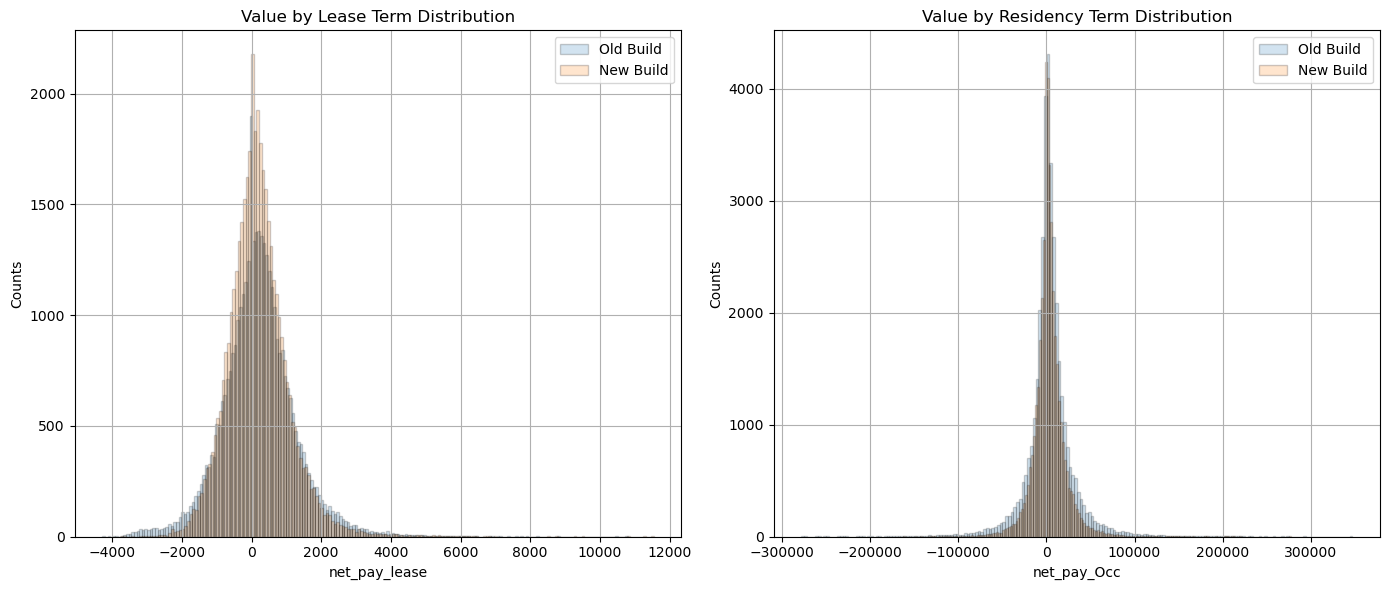

Median tenant Value (by lease length) for old build: 158.85002815647994
Median tenant Value (by lease length) for new build: 124.59934788466987
Median tenant Value (by residency length) for old build: 1928.6096753159995
Median tenant Value (by residency length) for new build: 1362.0591670880008


In [81]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns
# Histogram for move in year
build_year_plot('net_pay_lease',0,200)
# Histogram for move out year
build_year_plot('net_pay_Occ',1,200)
axes[0].set_title('Value by Lease Term Distribution')
axes[1].set_title('Value by Residency Term Distribution')
plt.savefig('year_build_value.png', dpi=500, bbox_inches='tight')  # Save as PNG
plt.tight_layout()
plt.show()
print('Median tenant Value (by lease length) for old build: '+ str(old_build['net_pay_lease'].median()))
print('Median tenant Value (by lease length) for new build: '+ str(new_build['net_pay_lease'].median()))
print('Median tenant Value (by residency length) for old build: '+ str(old_build['net_pay_Occ'].median()))
print('Median tenant Value (by residency length) for new build: '+ str(new_build['net_pay_Occ'].median()))

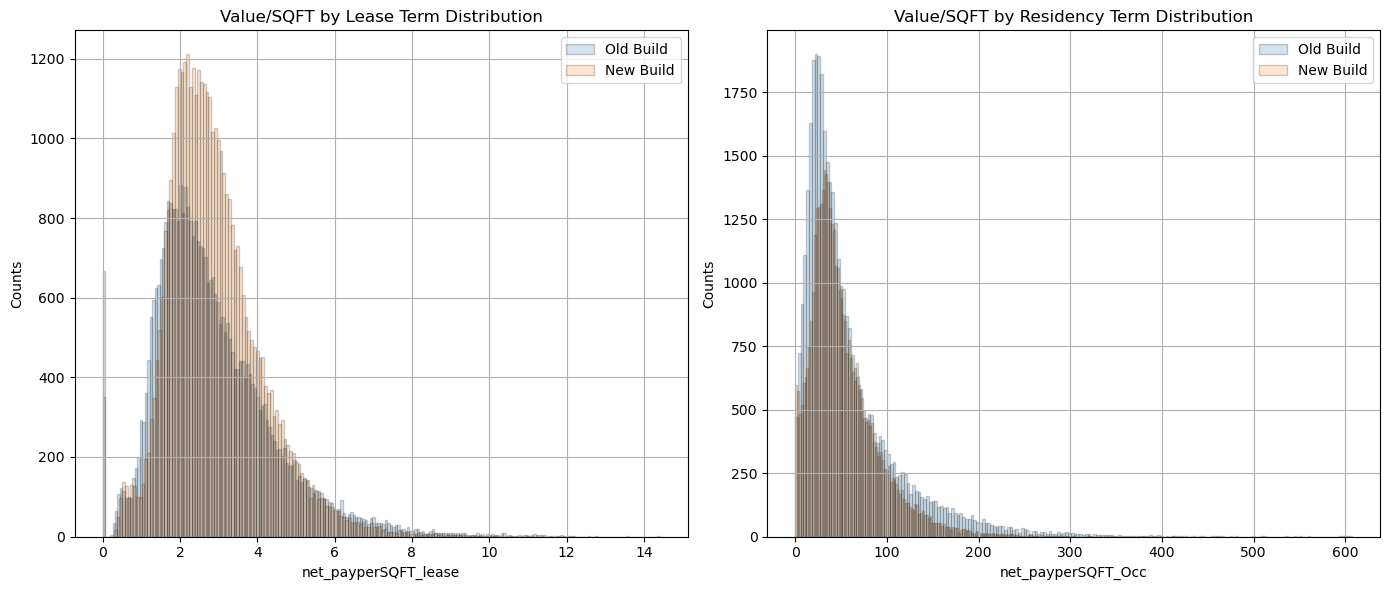

Median tenant Value (by lease length) for old build: 2.5428399010822575
Median tenant Value (by lease length) for new build: 2.7048706623042946
Median tenant Value (by residency length) for old build: 41.431636866806066
Median tenant Value (by residency length) for new build: 43.117058926181926


In [83]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns
# Histogram for move in year
build_year_plot('net_payperSQFT_lease',0,200)
# Histogram for move out year
build_year_plot('net_payperSQFT_Occ',1,200)
axes[0].set_title('Value/SQFT by Lease Term Distribution')
axes[1].set_title('Value/SQFT by Residency Term Distribution')
plt.savefig('year_build_valueperSQFT.png', dpi=500, bbox_inches='tight')  # Save as PNG
plt.tight_layout()
plt.show()
print('Median tenant Value (by lease length) for old build: '+ str(old_build['net_payperSQFT_lease'].median()))
print('Median tenant Value (by lease length) for new build: '+ str(new_build['net_payperSQFT_lease'].median()))
print('Median tenant Value (by residency length) for old build: '+ str(old_build['net_payperSQFT_Occ'].median()))
print('Median tenant Value (by residency length) for new build: '+ str(new_build['net_payperSQFT_Occ'].median()))

## Closer look at higher (non-trivial) correlations --> Not clear to me that I see any patterns

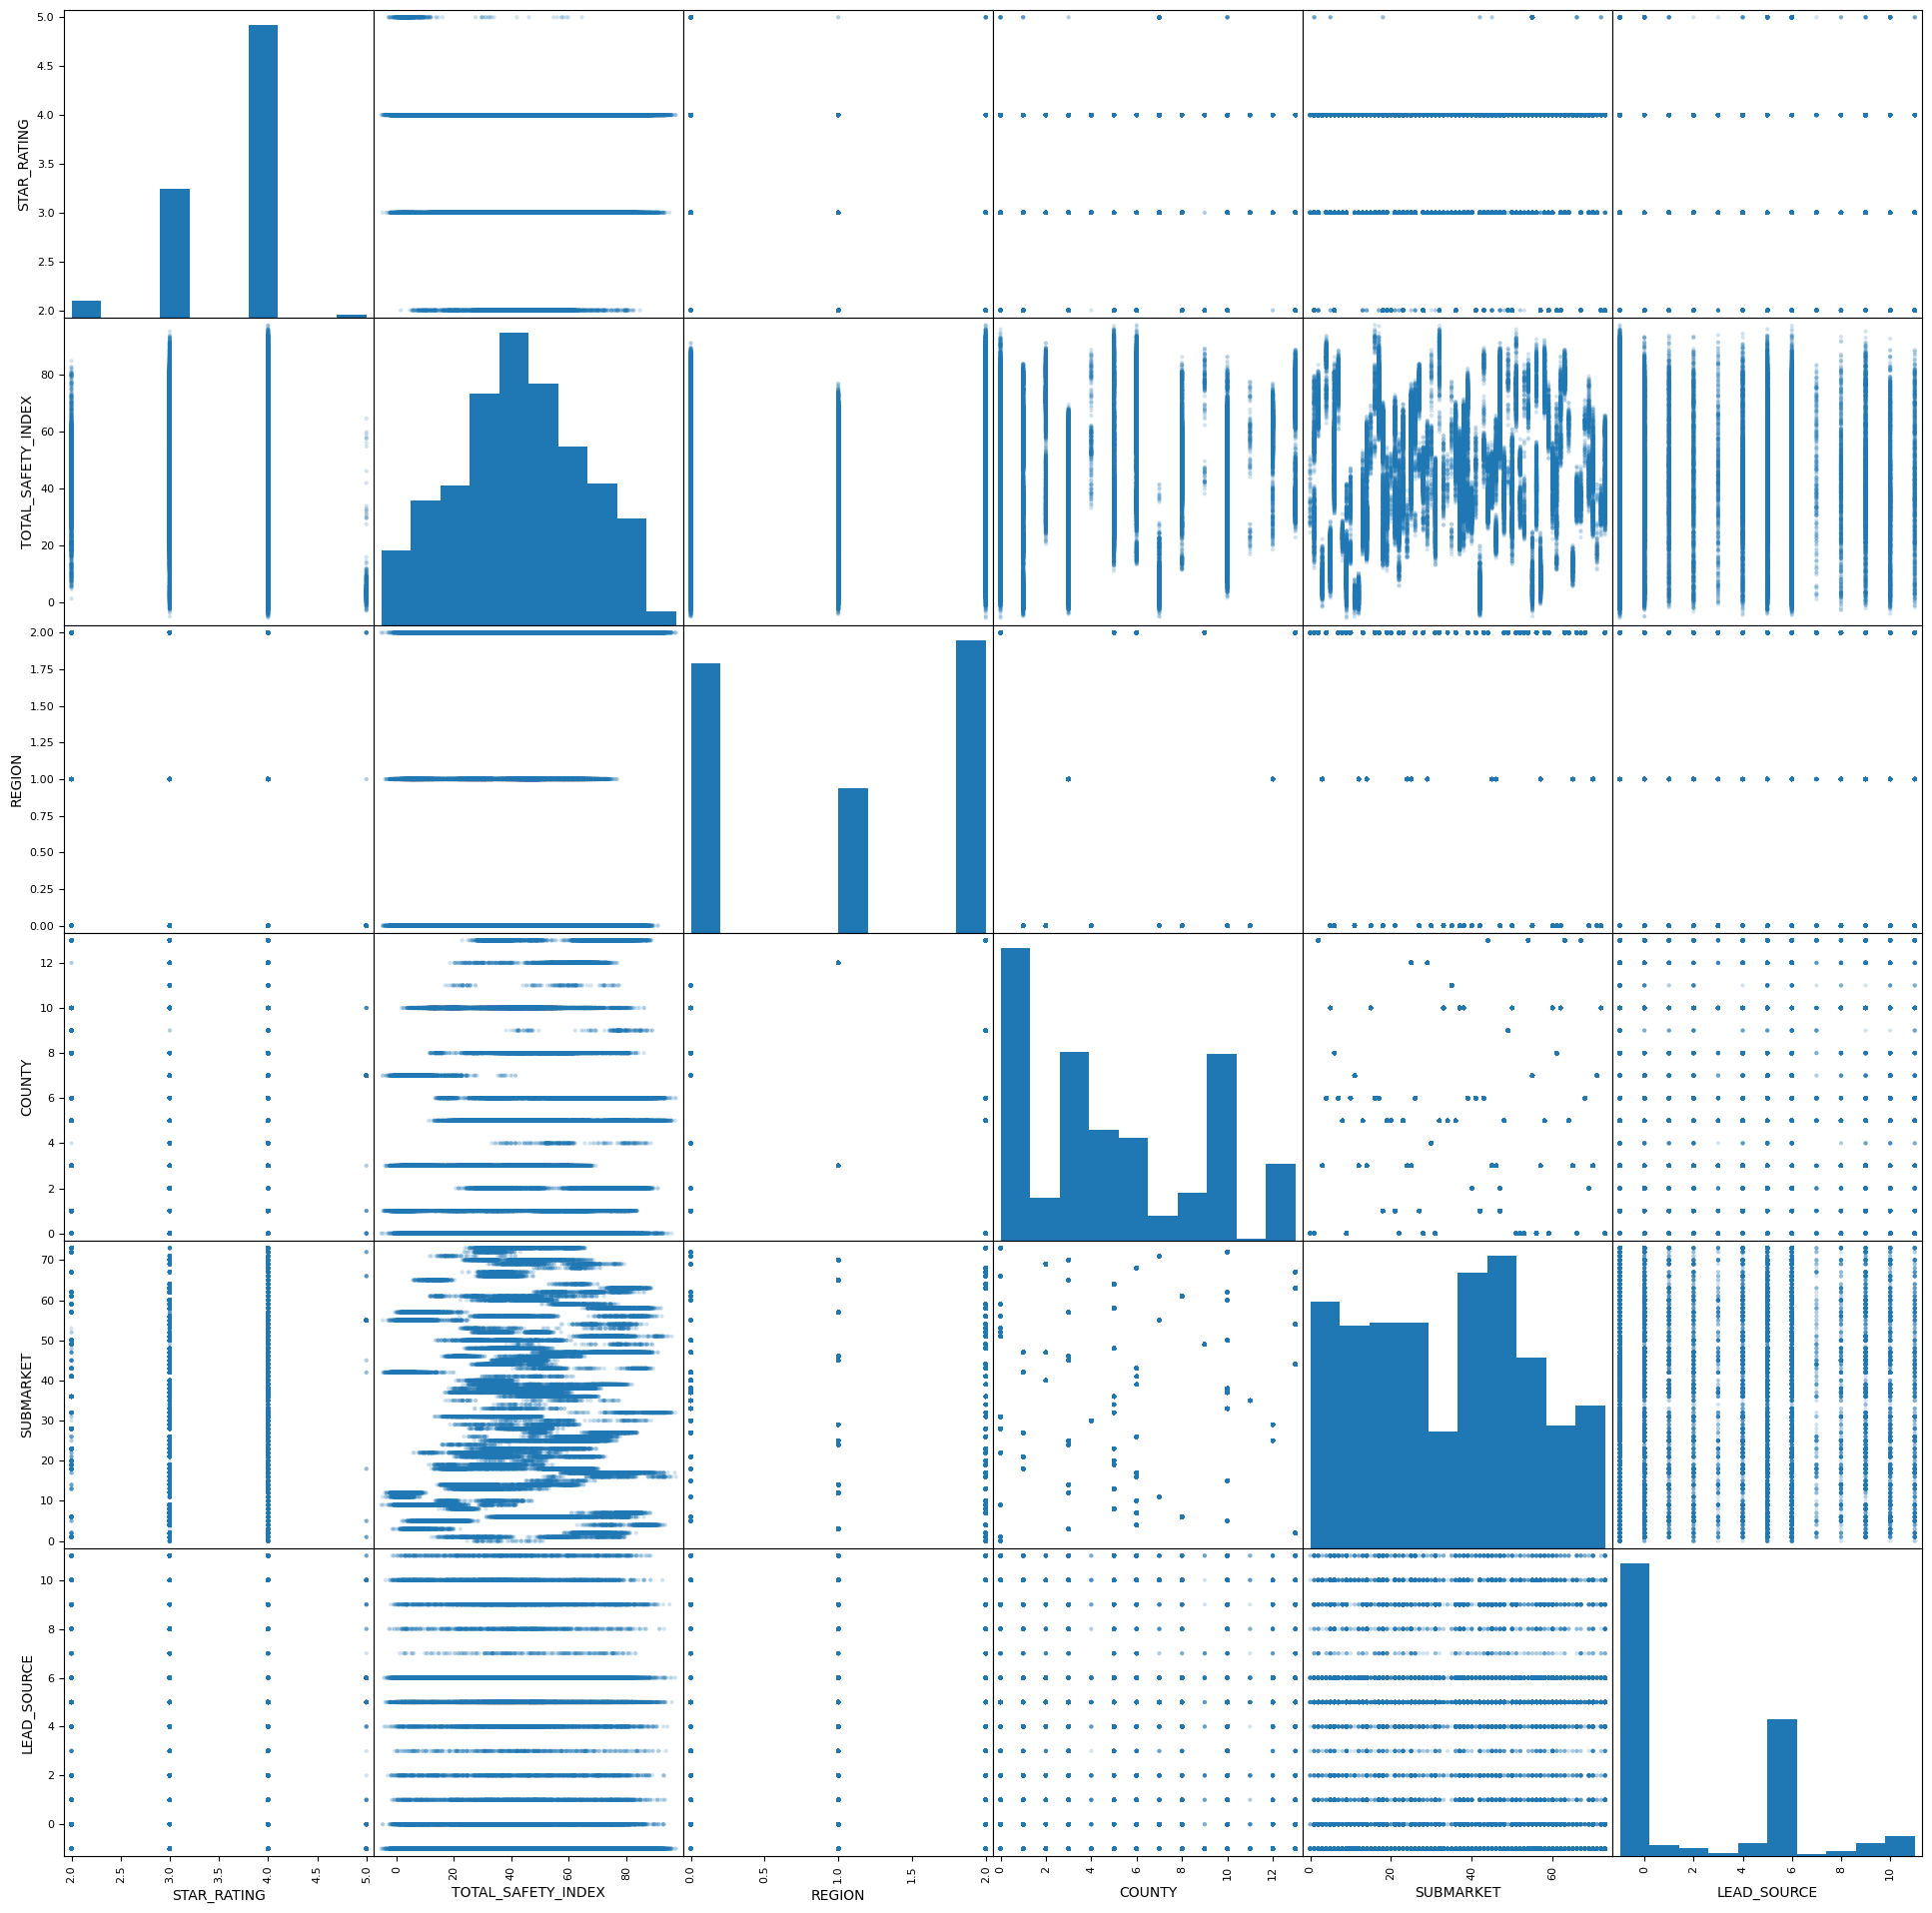

In [86]:
#attributes = ['YEAR_BUILT','MOVEINYEAR','MOVEOUTYEAR','CLOSEST_TRANSIT_STOP_DIST_MI','LEAD_SOURCE','OccVsLease']
#attributes= ['REGION','MEDIAN_HOME_PRICE','MOVEINYEAR','YEAR_BUILT']
attributes = ['STAR_RATING','TOTAL_SAFETY_INDEX','REGION','COUNTY','SUBMARKET','LEAD_SOURCE']
scatter_matrix(tenants[attributes], figsize =(24,24), alpha =0.2)
plt.show()

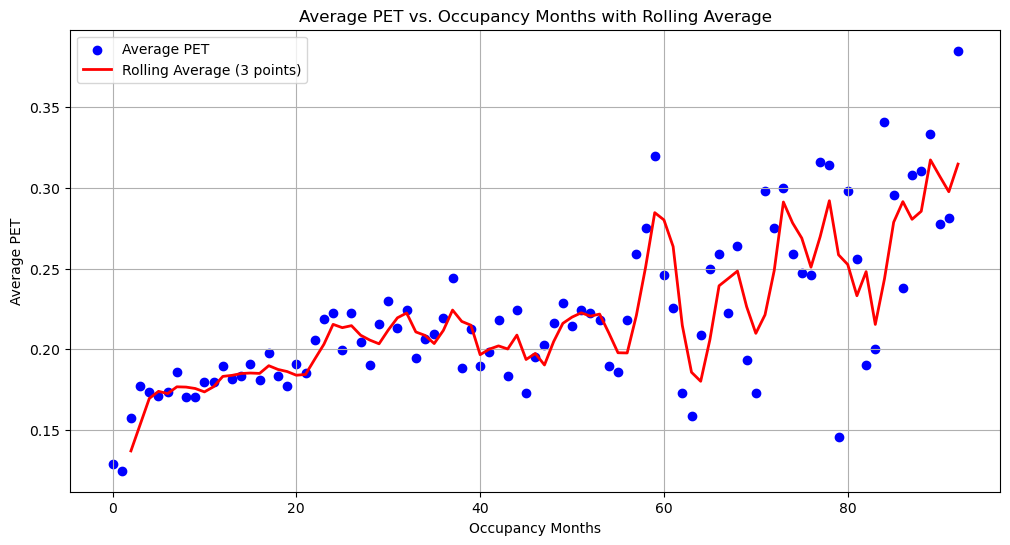

In [87]:
g = tenants.groupby(['OccupancyMonths'])
y = g['PET'].sum()/g['PET'].count()
y = y.reset_index() 
y.columns = ['OccupancyMonths','AvePETperpop']
y['RollingAvgPET'] = y['AvePETperpop'].rolling(window=3).mean()

# Plotting
plt.figure(figsize=(12, 6))
plt.scatter(y['OccupancyMonths'],y['AvePETperpop'], label='Average PET', color='blue', marker='o')
plt.plot(y['OccupancyMonths'],y['RollingAvgPET'], label='Rolling Average (3 points)', color='red', linestyle='-', linewidth=2)
plt.title('Average PET vs. Occupancy Months with Rolling Average')
plt.xlabel('Occupancy Months')
plt.ylabel('Average PET')
plt.grid(True)
plt.legend()
plt.show()

## A larger fraction of tenant with pets sign for leases with longer terms

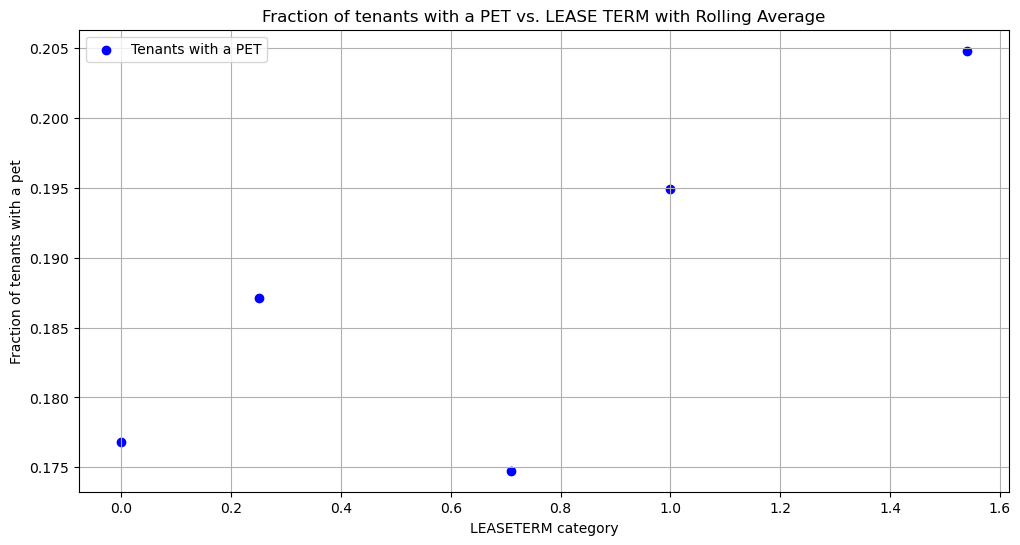

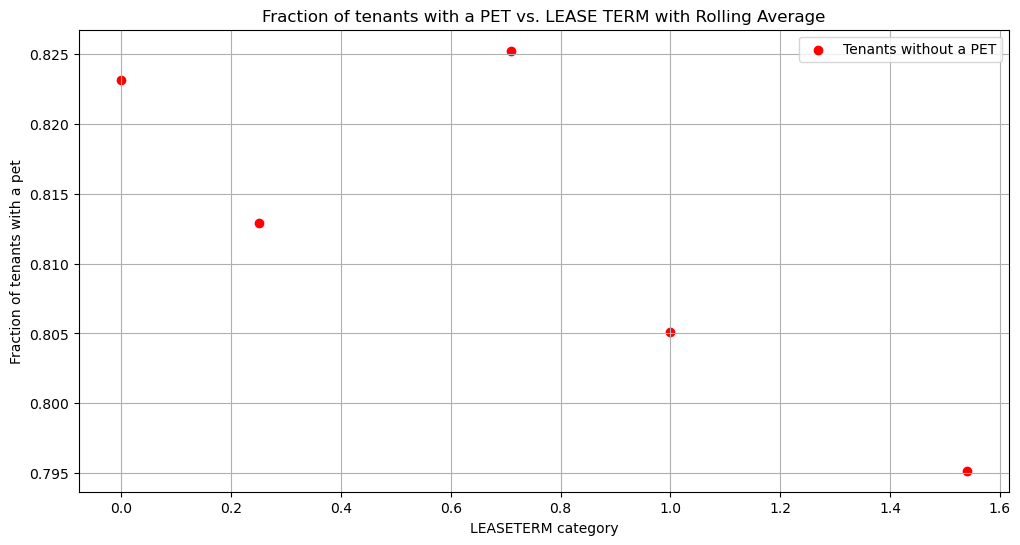

In [89]:
g = tenants.groupby(['LEASETERM'])
y = g['PET'].sum()/g['PET'].count()
z = g['PET'].std()
y = pd.concat([y,z],axis=1).reset_index()
y.columns = ['LEASETERM','AvePETperpop','std_PET']
y['No_Pet'] = 1-y['AvePETperpop']
# Plotting
plt.figure(figsize=(12, 6))
plt.scatter(y['LEASETERM'], y['AvePETperpop'], label='Tenants with a PET', color='blue', marker='o')
plt.title('Fraction of tenants with a PET vs. LEASE TERM with Rolling Average')
plt.xlabel('LEASETERM category')
plt.ylabel('Fraction of tenants with a pet')
plt.grid(True)
plt.legend()
plt.savefig('fract_pets_by_lease.png', dpi=500, bbox_inches='tight')  # Save as PNG
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(y['LEASETERM'], y['No_Pet'], label='Tenants without a PET', color='red', marker='o')
plt.title('Fraction of tenants with a PET vs. LEASE TERM with Rolling Average')
plt.xlabel('LEASETERM category')
plt.ylabel('Fraction of tenants with a pet')
plt.grid(True)
plt.legend()
plt.savefig('fract_nopets_by_lease.png', dpi=500, bbox_inches='tight')  # Save as PNG
plt.show()

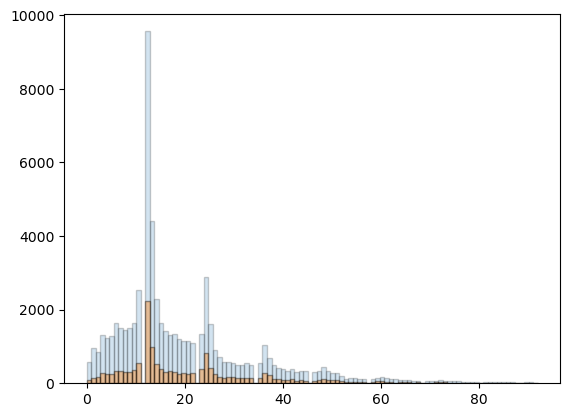

In [90]:
with_pet = tenants[tenants['PET']==1]
no_pet = tenants[tenants['PET']==0]
plt.hist(no_pet['OccupancyMonths'], bins=100, edgecolor='black', alpha=0.2)
plt.hist(with_pet['OccupancyMonths'], bins=100, edgecolor='black', alpha=0.4)
plt.show()

## If I had more time, I'd look at how income, industry, and geography relate the rent (what tenants can afford) and to their net_pay (profitability to the landlord).

# Q3. Based on the factors that make a tenant "valuable," provide recommendations for possible actions from the findings.

- Smaller apartment sizes and higher rent + amenity costs make the tenants in the new builds valuable. When purchasing and leasing a new build, prioritizing smaller apartment size and longer lease terms is beneficial.
- When considering the value of tenants of older builds, longer residencies are likely to be more important. Maybe introduce perks or benefits for longer residencies and lease renewals in these buildings.
- Considering each lease group, the proportion of pet owners is higher for longer lease terms. When prioritizing signing longer lease terms, try to tap into this market by providing incentives. However, more data on the state of the apartment and cost of repairs after tenant vacancy would help determine if it’s worth pursuing more tenants with pets.


# Q4. Lastly, propose other metrics to define a "valuable" tenant which aren't already covered in your analysis. Also suggest additional features which could be strong predictors of a "valuable" tenant.

### Cost of the building purchase, maintenance and upkeep:
- These factors would deduct from their profitibilty.
- Old builds may be located more centrally (their proximity to public transportation in this dataset) which (depending on when they were acquired) could reflect a higher price. They may require more upkeep and update costs for older windows, plumbing, etc.
- New builds may have a higher initial cost as they have more updated finishes and amenities as we see with the greater cost of amenities to tenants here.

### Tenant Behavior (Scores):
Stable tenants who pay their rent on time and maintain the property well enhance their overall value, regardless of lease or residency length. Employee perception of tenants could be a strong indicator of tenants behavior towards others and their use of shared spaces.

### Cost of repairs after tenant vacancy:
This would deduct from the profitability of tenants and may be related to factors such as pet ownership. Could also help determine how much to charge as an amenity cost for pet residency.

### Noise complaints or complaints from other tenants:
Tracking these can help determine whether tenants are increasing or decreasing the satisfaction of other tenants with the property.

### Rent increase rates or other rates related to market conditions:
In a rapidly changing rental market, lease terms might need more frequent review to ensure they reflect current conditions.

### Renewal data for each tenant:
Information on this for each tenant would be useful as many tenants are residing past their lease periods so it's unclear what policy applies during these excess times.

### Geographical Data:
If we had more geographical data on the location of the properties such as longitudinal and latitudinal location, we might be able to better figure out how valuable tenants prioritize location. Especially if industry is a predictor of tenant incomes and value and tenants prefer to be geographically closer to work.

# Q Bonus: If you can, please build a predictive model either used above or new to identify future "valuable" tenant. Please validate how good your model is.

# Prepare data for ML

## Transformations

In [102]:
temp = tenants.copy()
attributes_for_standard_transform = ['PROPERTYID','AMENITY_AMOUNT','RENT','SQFT','SUB_OCCUPANCY','SUB_ASKING_RENT',
                                     'SUB_CONCESSION_ASKING_PCT','PRIMARY_AGE_AT_MOVE_IN',
                                     'TOTAL_SAFETY_INDEX','MEDIAN_HOME_PRICE','BEDS','COUNTY','REGION',
                                     'CONCESSION','SUB_PCT_CONCESSIONS_OFFER','CLOSEST_TRANSIT_STOP_DIST_MI','STAR_RATING',
                                     'YEARLY_ADJUSTED_INCOME','PCT_UNEMPLOYMENT','TOTAL_OF_OCCUPANTS','OccupancyMonths',
                                     'SUBMARKET','LEAD_SOURCE','MoveInMnum','net_payperSQFT_lease','net_payperSQFT_Occ','net_pay_lease','net_pay_Occ'] 
attributes_for_log_transform = ['YEARLY_ADJUSTED_INCOME']#['CONCESSION','CLOSEST_TRANSIT_STOP_DIST_MI','SUB_PCT_CONCESSIONS_OFFER',
                                #'YEARLY_ADJUSTED_INCOME','PCT_UNEMPLOYMENT','TOTAL_OF_OCCUPANTS','OccupancyMonths']
attributes_for_bimodal_transform = ['YEAR_BUILT']

std_scaler = StandardScaler()
log_transformer = FunctionTransformer(np.log, inverse_func =np.exp)

temp[attributes_for_log_transform]= log_transformer.transform(tenants[attributes_for_log_transform])
temp[attributes_for_standard_transform]= std_scaler.fit_transform(tenants[attributes_for_standard_transform])
temp[attributes_for_bimodal_transform] = np.where(tenants[attributes_for_bimodal_transform] < 1925, 0, 1)

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [104]:
# Drop columns that are identifiers and used to calculate value of tenants
X_train = temp.drop(columns=['PROPERTYID','TENANTCODE','UNITID', 'AMENITY_AMOUNT','RENT','CONCESSION',
                        'LEASETERM','SQFT','SUB_ASKING_RENT','SUB_CONCESSION_ASKING_PCT','OccVsLease',
                        'Payment', 'Ideal_Payment', 'net_pay', 'PaymentperSQFT', 'MoveInMnum', 'MoveOutMnum',
                        'net_payperSQFT', 'net_payperSQFT_lease', 'net_payperSQFT_Occ', 'net_pay_lease', 'net_pay_Occ']) #'MOVEINYEAR', 'MOVEINMONTH', 'MOVEOUTYEAR','MOVEOUTMONTH',
Y_train = temp['net_payperSQFT_lease']
print('Training on attributes: ')
print(X_train.keys())
Y_train.reset_index()
X_train.reset_index()

Training on attributes: 
Index(['BEDS', 'COUNTY', 'REGION', 'SUBMARKET', 'STAR_RATING', 'YEAR_BUILT',
       'CLOSEST_TRANSIT_STOP_DIST_MI', 'LEAD_SOURCE', 'TYPE_OF_MOVE',
       'SUB_OCCUPANCY', 'SUB_PCT_CONCESSIONS_OFFER', 'PET', 'INDUSTRY',
       'PRIMARY_AGE_AT_MOVE_IN', 'YEARLY_ADJUSTED_INCOME',
       'TOTAL_OF_OCCUPANTS', 'PCT_UNEMPLOYMENT', 'TOTAL_SAFETY_INDEX',
       'MEDIAN_HOME_PRICE', 'MOVEINYEAR', 'MOVEINMONTH', 'MOVEOUTYEAR',
       'MOVEOUTMONTH', 'OccupancyMonths'],
      dtype='object')


index      BEDS    COUNTY    REGION  SUBMARKET  STAR_RATING  \
0      10284  0.858706  0.257127  1.084789  -0.843147     0.640334   
1      57225  0.858706 -0.986429 -1.158684   0.402950     0.640334   
2      37369  2.291017 -0.489006 -0.036947   0.552482    -1.125983   
3      91583  0.858706 -0.737717 -1.158684   0.652170    -1.125983   
4      82002  0.858706 -1.235140  1.084789   1.948111     0.640334   
...      ...       ...       ...       ...        ...          ...   
79995  35023 -0.573605 -0.986429 -1.158684  -0.793303    -1.125983   
79996  43894 -0.573605  0.257127  1.084789  -0.843147    -1.125983   
79997  86698  0.858706 -1.235140  1.084789   1.948111     0.640334   
79998  56470  0.858706  0.008416  1.084789  -0.544083    -2.892300   
79999  80952 -0.573605  0.008416  1.084789  -0.544083     0.640334   

       YEAR_BUILT  CLOSEST_TRANSIT_STOP_DIST_MI  LEAD_SOURCE  TYPE_OF_MOVE  \
0               0                     -0.489421    -0.823036             1   
1               1                      1.260504     1.145101             0   
2               1                      2.008534     2.269751             2   
3               1                      1.058962    -0.823036             0   
4               1                     -0.518490     0.863939             0   
...           ...                           ...          ...           ...   
79995           1                     -0.439036     1.707426             0   
79996           1                      3.591799     1.145101             2   
79997           0                     -0.489421    -0.823036             2   
79998           1                      0.090011    -0.541874             2   
79999           0                     -0.489421     1.988588             2   

       ...  YEARLY_ADJUSTED_INCOME  TOTAL_OF_OCCUPANTS  PCT_UNEMPLOYMENT  \
0      ...               -0.190202            0.108882         -0.290446   
1      ...               -0.408910            0.108882          0.901516   
2      ...               -0.155733            0.108882         -0.636132   
3      ...               -0.133319            1.600163         -0.258625   
4      ...               -0.108306           -1.382399          1.834436   
...    ...                     ...                 ...               ...   
79995  ...                0.162972            0.108882          0.923156   
79996  ...               -0.191200            1.600163         -0.429180   
79997  ...               -0.053092            0.108882         -0.135453   
79998  ...               -0.174132            0.108882         -0.523479   
79999  ...               -0.053092            0.108882         -0.777576   

       TOTAL_SAFETY_INDEX  MEDIAN_HOME_PRICE  MOVEINYEAR  MOVEINMONTH  \
0                1.583238          -1.066548        2017            1   
1               -1.943666          -0.906887        2020           12   
2                0.298351           0.654120        2022           11   
3                1.326839           2.093763        2023            1   
4                0.494904          -0.277789        2021            2   
...                   ...                ...         ...          ...   
79995            0.746946           0.258977        2021            3   
79996            1.174844          -0.057137        2022           11   
79997            0.855312          -0.702064        2019            8   
79998           -0.753024           0.339715        2023            5   
79999           -0.518322          -0.394909        2018           12   

       MOVEOUTYEAR  MOVEOUTMONTH  OccupancyMonths  
0           2020.0           1.0         1.010800  
1           2022.0           7.0        -0.094187  
2           2023.0           7.0        -0.809179  
3           2024.0           9.0        -0.029188  
4           2023.0           2.0         0.230809  
...            ...           ...              ...  
79995       2022.0           3.0        -0.549182  
79996       2024.0     

# Select and train a model

### Linear Regression

In [108]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)
Y_predict = lin_reg.predict(X_train)

lin_rmse = mean_squared_error(Y_train, Y_predict, squared = False)
print(lin_rmse)
print(Y_train.median())
# --> Not good at all

0.8402759846880099
-0.16954147954878973


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Decision Tree

In [111]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, Y_train)
Y_predict = tree_reg.predict(X_train)

tree_rmse = mean_squared_error(Y_train, Y_predict, squared = False)
print(tree_rmse)
print(np.median(Y_predict))
print(Y_train.median())
# --> Suspiciously good --> probably overfitting

0.0
-0.16954147954878973
-0.16954147954878973


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Random Forest Regressor

In [114]:
from sklearn.ensemble import RandomForestRegressor


forest_reg = RandomForestRegressor()
forest_reg.fit(X_train, Y_train)
Y_predict = forest_reg.predict(X_train)

forest_rmse = mean_squared_error(Y_train, Y_predict) # squared = False

In [115]:
print(forest_rmse)
print('Median Y_train'+ str(Y_train.median()))
print('Median Y_predict'+ str(np.median(Y_predict)))
# --> Pretty good! But could be overfitting

0.05609149646173711
Median Y_train-0.16954147954878973
Median Y_predict-0.15783705822159338


### Cross Validation

In [195]:
from sklearn.model_selection import cross_val_score
forest_rmses = cross_val_score(forest_reg,X_train, Y_train, scoring ='neg_root_mean_squared_error', cv = 10)

In [196]:
pd.Series(forest_rmses).describe()

count    10.000000
mean     -0.624206
std       0.010088
min      -0.643434
25%      -0.631328
50%      -0.621622
75%      -0.619543
max      -0.609498
dtype: float64

In [197]:
Y_predict

array([-0.33785667, -0.71249152, -1.10052754, ...,  0.49697667,
        0.09522596,  1.91416888])

# Fine-tune
## Grid search
### This step didn't complete and took very long to execute -- consider skipping execution until improved

In [230]:
from sklearn.model_selection import train_test_split, GridSearchCV
# Define the parameter grid for Grid Search
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_features': ['auto', 'sqrt'], # Number of features to consider when looking for the best split
    'max_depth': [None, 10, 20],      # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]     # Minimum number of samples required to be at a leaf node
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=forest_reg, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5, 
                           verbose=1, n_jobs=-1)  # Use all available cores

# Fit the grid search model
grid_search.fit(X_train, Y_train)

# Get the best model from grid search
best_forest = grid_search.best_estimator_

# Predict using the best model
Y_predict = best_forest.predict(X_train)

# Calculate RMSE for the predictions
forest_rmse = np.sqrt(mean_squared_error(Y_train, Y_predict))  # Use np.sqrt for RMSE
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Random Forest RMSE: {forest_rmse}')
print(f'Median of Y_train: {Y_train.median()}')

Fitting 5 folds for each of 162 candidates, totalling 810 fits


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
405 fits failed out of a total of 810.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
405 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/s

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest RMSE: 0.22950260262314998
Median of Y_train: -0.16954147954878973


### That didn't work very well. If I had more time, I'd troubleshoot some more.

# Make DATA PIPELINE: Bring back the test set!

In [117]:
# Now, lets test this on the test set. If I had more time I'd write a proper pipeline using make_pipeline,
# but I'm just going to copy the functions here and apply them to the tst set
tenants_test = test_set #IMPORT TEST SET INSTEAD

In [118]:
# Transforms
med_impute_columns = ['SUB_OCCUPANCY','SUB_ASKING_RENT','SUB_CONCESSION_ASKING_PCT','PRIMARY_AGE_AT_MOVE_IN','TOTAL_OF_OCCUPANTS','PCT_UNEMPLOYMENT','MEDIAN_HOME_PRICE'] #YEARLY_ADJUSTED_INCOME
mean_impute_columns = ['SUB_PCT_CONCESSIONS_OFFER']

tenants_test[med_impute_columns] = imputer_median.fit_transform(tenants_test[med_impute_columns])
tenants_test[mean_impute_columns] = imputer_mean.fit_transform(tenants_test[mean_impute_columns])
pet_nans(tenants_test)
moveout_nan(tenants_test)
lease_nans_transform(tenants_test)
move_nans(tenants_test)
industry_nans(tenants_test)
tenants_test['INDUSTRY'] = ordinal_encoder.fit_transform(tenants_test[['INDUSTRY']])
impute_income_medians(tenants_test)

### Simplifying the time data
tenants_test['MoveInMnum'] = 12*(tenants_test['MOVEINYEAR'] - tenants_test['MOVEINYEAR'].min()) + (tenants_test['MOVEINMONTH'] - tenants_test[tenants_test['MOVEINYEAR']==tenants_test['MOVEINYEAR'].min()]['MOVEINMONTH'].min())
tenants_test['MoveOutMnum'] = 12*(tenants_test['MOVEOUTYEAR'] - tenants_test['MOVEINYEAR'].min()) + (tenants_test['MOVEOUTMONTH'] - tenants_test[tenants_test['MOVEINYEAR']==tenants_test['MOVEINYEAR'].min()]['MOVEINMONTH'].min())
tenants_test['OccupancyMonths'] = tenants_test['MoveOutMnum'] - tenants_test['MoveInMnum']
tenants_test['OccVsLease'] = tenants_test.apply(occtolease, axis=1)

tenants_test['Payment'] = tenants_test['RENT'] + tenants_test['AMENITY_AMOUNT'] - tenants_test['CONCESSION']
tenants_test['Ideal_Payment'] = tenants_test['SUB_ASKING_RENT'] - tenants_test['SUB_CONCESSION_ASKING_PCT']
tenants_test['net_pay'] = tenants_test['Payment'] - tenants_test['Ideal_Payment']
tenants_test['PaymentperSQFT'] = tenants_test['Payment']/tenants_test['SQFT']
tenants_test['net_payperSQFT'] = tenants_test['Ideal_Payment']/tenants_test['SQFT']
tenants_test['net_pay_lease'] = tenants_test['net_pay']*tenants_test['LEASETERM']
tenants_test['net_pay_Occ'] = tenants_test['net_pay']*tenants_test['OccupancyMonths']
tenants_test['net_payperSQFT_lease'] = tenants_test['net_payperSQFT']*tenants_test['LEASETERM']
tenants_test['net_payperSQFT_Occ'] = tenants_test['net_payperSQFT']*tenants_test['OccupancyMonths']

/var/folders/1w/f1nvvnys0db1_sj90qqds2780000gn/T/ipykernel_55760/1551715802.py:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['LEASETERM'] = df['LEASETERM'].replace(mapping)
/var/folders/1w/f1nvvnys0db1_sj90qqds2780000gn/T/ipykernel_55760/1551715802.py:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['TYPE_OF_MOVE'] = df['TYPE_OF_MOVE'].replace(mapping)


## Evaluate on test data

In [156]:
#Copy of test data
temp = tenants_test.copy()

#Same attributes to scale transform as above
attributes_for_standard_transform = ['PROPERTYID','AMENITY_AMOUNT','RENT','SQFT','SUB_OCCUPANCY','SUB_ASKING_RENT',
                                     'SUB_CONCESSION_ASKING_PCT','PRIMARY_AGE_AT_MOVE_IN',
                                     'TOTAL_SAFETY_INDEX','MEDIAN_HOME_PRICE','BEDS','COUNTY','REGION',
                                     'CONCESSION','SUB_PCT_CONCESSIONS_OFFER','CLOSEST_TRANSIT_STOP_DIST_MI','STAR_RATING',
                                     'YEARLY_ADJUSTED_INCOME','PCT_UNEMPLOYMENT','TOTAL_OF_OCCUPANTS','OccupancyMonths',
                                     'SUBMARKET','LEAD_SOURCE','MoveInMnum','net_payperSQFT_lease','net_payperSQFT_Occ','net_pay_lease','net_pay_Occ'] 
attributes_for_log_transform = ['YEARLY_ADJUSTED_INCOME']
attributes_for_bimodal_transform = ['YEAR_BUILT']

std_scaler = StandardScaler()
log_transformer = FunctionTransformer(np.log, inverse_func =np.exp)

temp[attributes_for_log_transform]= log_transformer.transform(temp[attributes_for_log_transform])
temp[attributes_for_standard_transform]= std_scaler.fit_transform(temp[attributes_for_standard_transform])
temp[attributes_for_bimodal_transform] = np.where(temp[attributes_for_bimodal_transform] < 1925, 0, 1)

# Drop columns that are identifiers and used to calculate value of tenants
X_train = temp.drop(columns=['PROPERTYID','TENANTCODE','UNITID', 'AMENITY_AMOUNT','RENT','CONCESSION',
                        'LEASETERM','SQFT','SUB_ASKING_RENT','SUB_CONCESSION_ASKING_PCT','OccVsLease',
                        'Payment', 'Ideal_Payment', 'net_pay', 'PaymentperSQFT', 'MoveInMnum', 'MoveOutMnum',
                        'net_payperSQFT', 'net_payperSQFT_lease', 'net_payperSQFT_Occ', 'net_pay_lease', 'net_pay_Occ']) #'MOVEINYEAR', 'MOVEINMONTH', 'MOVEOUTYEAR','MOVEOUTMONTH',
Y_train = temp['net_payperSQFT_lease']
print('Training on attributes: ')
print(X_train.keys())
Y_train.reset_index()
X_train.reset_index()
X_train.dropna(inplace=True) #There's 5 rows with nan and I'm not sure why I'm getting this.
                            #There isn't an issue with the generality of the functions, so I'm dropping these 5 rows
Y_train = Y_train[X_train.index]  # Keep Y_train aligned with cleaned X_train

Training on attributes: 
Index(['BEDS', 'COUNTY', 'REGION', 'SUBMARKET', 'STAR_RATING', 'YEAR_BUILT',
       'CLOSEST_TRANSIT_STOP_DIST_MI', 'LEAD_SOURCE', 'TYPE_OF_MOVE',
       'SUB_OCCUPANCY', 'SUB_PCT_CONCESSIONS_OFFER', 'PET', 'INDUSTRY',
       'PRIMARY_AGE_AT_MOVE_IN', 'YEARLY_ADJUSTED_INCOME',
       'TOTAL_OF_OCCUPANTS', 'PCT_UNEMPLOYMENT', 'TOTAL_SAFETY_INDEX',
       'MEDIAN_HOME_PRICE', 'MOVEINYEAR', 'MOVEINMONTH', 'MOVEOUTYEAR',
       'MOVEOUTMONTH', 'OccupancyMonths'],
      dtype='object')


/opt/anaconda3/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [158]:
print("NaN values in X_train:")
print(X_train.isnull().sum())

print("NaN values in Y_train:")
print(Y_train.isnull().sum())

NaN values in X_train:
BEDS                            0
COUNTY                          0
REGION                          0
SUBMARKET                       0
STAR_RATING                     0
YEAR_BUILT                      0
CLOSEST_TRANSIT_STOP_DIST_MI    0
LEAD_SOURCE                     0
TYPE_OF_MOVE                    0
SUB_OCCUPANCY                   0
SUB_PCT_CONCESSIONS_OFFER       0
PET                             0
INDUSTRY                        0
PRIMARY_AGE_AT_MOVE_IN          0
YEARLY_ADJUSTED_INCOME          0
TOTAL_OF_OCCUPANTS              0
PCT_UNEMPLOYMENT                0
TOTAL_SAFETY_INDEX              0
MEDIAN_HOME_PRICE               0
MOVEINYEAR                      0
MOVEINMONTH                     0
MOVEOUTYEAR                     0
MOVEOUTMONTH                    0
OccupancyMonths                 0
dtype: int64
NaN values in Y_train:
0


In [128]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)
Y_predict = lin_reg.predict(X_train)

lin_rmse = mean_squared_error(Y_train, Y_predict, squared = False)
print('RMSE Error: ' + str(lin_rmse))
print('Median Y_train'+ str(Y_train.median()))
print('Median Y_predict'+ str(np.median(Y_predict)))
# --> Not good at all

RMSE Error: 0.8407873395464107
Median Y_train-0.17249833092965838
Median Y_predict0.007192343473434448


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [130]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, Y_train)
Y_predict = tree_reg.predict(X_train)

tree_rmse = mean_squared_error(Y_train, Y_predict, squared = False)

print('RMSE Error: ' + str(tree_rmse))
print('Median Y_train'+ str(Y_train.median()))
print('Median Y_predict'+ str(np.median(Y_predict)))
# --> Still good on the test set! 

RMSE Error: 0.0
Median Y_train-0.17249833092965838
Median Y_predict-0.17249833092965838


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [168]:
forest_reg = RandomForestRegressor()
forest_reg.fit(X_train, Y_train)
Y_predict = forest_reg.predict(X_train)

forest_rmse = mean_squared_error(Y_train, Y_predict) # squared = False
print('RMSE Error: ' + str(forest_rmse))
print('Median Y_train'+ str(Y_train.median()))
print('Median Y_predict'+ str(np.median(Y_predict)))
# --> Pretty good! But could be overfitting

RMSE Error: 0.06228888981390386
Median Y_train-0.17249833092965838
Median Y_predict-0.15446658544660993


## --> 6% error for the random forest regressor is pretty good! The Decision Tree seems to be performing better despite being simpler. I'm very suspicious of the RMSE of 0.0 and suspect an issue with my analysis.
## Train Set Error: 0.0557
## Test Set Error: 0.0619
## The bias and variance of the model seem to both be low. Indicating it isn't overfitted.


In [216]:
Y_predict_df = pd.DataFrame(Y_predict)
Y_predict_df.columns = ['Y_predict']
Y_predict_df.reset_index()
Y_train_df = pd.DataFrame(Y_train)
Y_train_df = Y_train_df.reset_index()
final_df = pd.concat([X_train.reset_index(),Y_train_df,Y_predict_df],axis = 1)
final_df

index      BEDS    COUNTY    REGION  SUBMARKET  STAR_RATING  \
0      50435 -0.554831 -0.489545 -0.036683  -0.993068     0.646461   
1      76185 -1.983337 -1.235803  1.085122  -1.242326    -1.112378   
2      37805  0.873674 -0.738298 -1.158488   0.652030    -1.112378   
3      54131 -1.983337 -1.235803  1.085122  -1.242326     0.646461   
4        744 -0.554831 -1.235803  1.085122  -0.145594     0.646461   
...      ...       ...       ...       ...        ...          ...   
19990  49431  0.873674  1.251723 -1.158488  -1.441732     0.646461   
19991   6990 -0.554831 -0.489545 -0.036683   0.602178     0.646461   
19992  97200  0.873674  1.251723 -1.158488   0.801584     0.646461   
19993  53165  0.873674  0.007960  1.085122   0.701881     0.646461   
19994  18305  0.873674 -0.489545 -0.036683   0.552327    -1.112378   

       YEAR_BUILT  CLOSEST_TRANSIT_STOP_DIST_MI  LEAD_SOURCE  TYPE_OF_MOVE  \
0               0                     -0.493996    -0.833219             0   
1               1                     -0.480571     1.133311             3   
2               1                      3.157566     0.852378             2   
3               0                     -0.493996    -0.833219             1   
4               0                     -0.493996     1.133311             2   
...           ...                           ...          ...           ...   
19990           1                     -0.497831     2.257042             2   
19991           0                     -0.493996    -0.833219             0   
19992           1                     -0.271527     1.133311             1   
19993           1                     -0.146867     0.852378             2   
19994           1                      1.951246     1.976110             2   

       ...  TOTAL_SAFETY_INDEX  MEDIAN_HOME_PRICE  MOVEINYEAR  MOVEINMONTH  \
0      ...            0.259137          -0.841777        2019           11   
1      ...           -1.074433          -1.086445        2020           12   
2      ...            1.340518           1.389227        2022           12   
3      ...           -1.378679          -0.701449        2019           10   
4      ...           -0.555808           0.321810        2020            1   
...    ...                 ...                ...         ...          ...   
19990  ...           -1.067769           0.618551        2022            9   
19991  ...           -0.982661          -1.056874        2018            4   
19992  ...           -0.432191          -0.180502        2023            8   
19993  ...           -0.107152          -1.067163        2020           10   
19994  ...            0.273588          -0.319464        2020            5   

       MOVEOUTYEAR  MOVEOUTMONTH  OccupancyMonths  index  \
0           2020.0           7.0        -0.811392  50435   
1           2024.0           9.0         1.589195  76185   
2           2022.0          12.0        -1.330438  37805   
3           2024.0           9.0         2.497525  54131   
4           2021.0           1.0        -0.551869    744   
...            ...           ...              ...    ...   
19990       2023.0          10.0        -0.486988  49431   
19991       2019.0           4.0        -0.551869   6990   
19992       2024.0           9.0        -0.486988  97200   
19993       2021.0          10.0        -0.551869  53165   
19994       2020.0          12.0        -0.876273  18305   

       net_payperSQFT_lease  Y_predict  
0                 -0.631509  -0.531631  
1                  2.179645   2.104967  
2                 -0.319661  -0.535516  
3                  5.544987   5.131395  
4                  1.049868   0.930208  
...                     ...        ...  
19990             -0.533269  -0.496045  
19991             -0.416593  -0.454906  
19992             -0.425631  -0.376049  
19993             -1.189481  -1.089747  
19994             -1.286977  -1.184229  

[19995 rows x 28 columns]

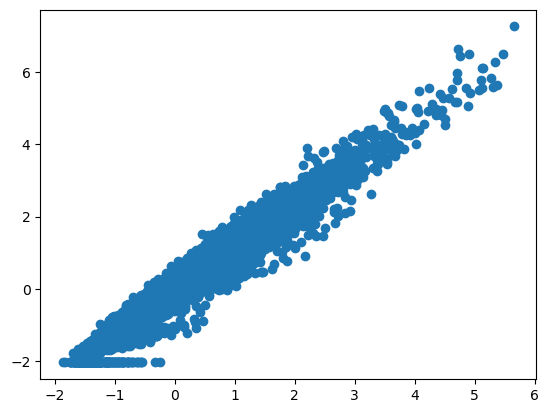

In [218]:
plt.scatter(final_df['Y_predict'],final_df['net_payperSQFT_lease'])